In [1]:
!date

Thu Jan  2 22:20:13 EST 2025


In [2]:
pwd

'/mmfs1/data/aglinska/BC-ABCD-denoise/Code'

In [3]:
%%time
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel.processing as nibp
from scipy import signal
from itertools import combinations_with_replacement
from numpy import savetxt
import nibabel as nib
import math
from numpy import random
import sklearn.preprocessing  
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from typing import List, Callable, Union, Any, TypeVar, Tuple
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn import linear_model

CPU times: user 963 ms, sys: 312 ms, total: 1.28 s
Wall time: 24.7 s


In [4]:
%%time
import ants
from tqdm import tqdm
import seaborn as sns

/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/data/aglinska/anaconda3/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


CPU times: user 1.01 s, sys: 535 ms, total: 1.55 s
Wall time: 25.5 s


In [5]:
def correlation(x,y):
  x_mean = np.repeat(x.mean(),x.shape,axis=0)
  y_mean = np.repeat(y.mean(),y.shape,axis=0)
  cov = (x-x_mean)*(y-y_mean)
  r = cov.sum()/(x.std()*y.std()*x.shape[0])
  return r

def remove_std0(arr):
    std0 = np.argwhere(np.std(arr, axis=1) == 0.0)
    arr_o = np.delete(arr,std0 ,axis=0) 
    return arr_o

def compute_in(x):
  return (x-3)/2+1

def compute_in_size(x):
  for i in range(4):
    x = compute_in(x)
  return x

def compute_out_size(x):
  return ((((x*2+1)*2+1)*2+1)*2+1)

def compute_padding(x):
  rounding = np.ceil(compute_in_size(x))-compute_in_size(x)
  y = ((((rounding*2)*2)*2)*2)
  pad = bin(int(y)).replace('0b', '')
  if len(pad) < 4:
      for i in range(4-len(pad)):
          pad = '0' + pad
  final_size = compute_in_size(x+y)
  pad_out = bin(int(compute_out_size(final_size)-x)).replace('0b','')
  if len(pad_out) < 4:
      for i in range(4-len(pad_out)):
          pad_out = '0' + pad_out
  return pad,final_size, pad_out

In [6]:
def correlate_columns(arr1, arr2):
    """
    Computes the Pearson correlation between corresponding columns of two matrices.
    
    Parameters:
    arr1 (np.ndarray): First matrix of shape (370, 1000)
    arr2 (np.ndarray): Second matrix of shape (370, 1000)
    
    Returns:
    np.ndarray: 1D array of correlations for each column (size 1000)
    """
    # Ensure input arrays are numpy arrays
    arr1 = np.asarray(arr1)
    arr2 = np.asarray(arr2)
    
    # Subtract the mean of each column (normalize)
    arr1_centered = arr1 - np.mean(arr1, axis=0)
    arr2_centered = arr2 - np.mean(arr2, axis=0)
    
    # Compute the numerator (covariance)
    numerator = np.sum(arr1_centered * arr2_centered, axis=0)
    
    # Compute the denominator (product of standard deviations)
    denominator = np.sqrt(np.sum(arr1_centered**2, axis=0) * np.sum(arr2_centered**2, axis=0))
    
    # Compute the Pearson correlation for each column
    correlation = numerator / denominator
    
    return correlation

def make_RDM(inVec,data_scale='ratio',metric='euclidean'):
    from scipy.spatial.distance import pdist
    from scipy.spatial.distance import squareform
    vec = inVec
    vec = (vec - min(vec.flatten())) / (max(vec.flatten())-min(vec.flatten()))
    
    if np.ndim(inVec)==1: # must be at least 2D
        vec = np.vstack((vec,np.zeros(vec.shape))).transpose()
                   
    mat = squareform(pdist(vec,metric=metric).transpose())
    if data_scale=='ordinal':
        mat[mat!=0]=1 # Make into zeros and ones
        
    return mat

def get_triu(inMat):
    assert np.ndim(inMat)==2, 'not 2 dim, wtf'
    assert inMat.shape[0]==inMat.shape[1], 'not a square'

    n = inMat.shape[0]
    triu_vec = inMat[np.triu_indices(n=n,k=1)]
    return triu_vec

In [7]:
def safe_mkdir(path):
    import os
    if not os.path.exists(path):
        os.mkdir(path)

In [8]:
class Scaler():
    def __init__(self,inputs):
        self.data = inputs
        self.mean = np.mean(inputs,axis=1)
        self.std = np.std(inputs, axis=1)
        self.vox, self.time = inputs.shape
    def transform(self,inputs):
        self.mean = np.reshape(self.mean,(self.vox,1))
        self.m_large = np.repeat(self.mean,self.time,axis=1)
        self.std = np.reshape(self.std,(self.vox,1))
        self.s_large = np.repeat(self.std,self.time,axis=1)
        return np.divide(inputs-self.m_large,self.s_large)
    def inverse_transform(self,outputs):
        return np.multiply(outputs,self.s_large)+self.m_large

In [9]:
# Alternative Scaler that Normalized between zero and 1
# class Scaler():
#     def __init__(self,inputs):
#         self.data = inputs
#         self.data_min = self.data.min(axis=1)[:,np.newaxis]
#         self.data_max = self.data.max(axis=1)[:,np.newaxis]
#         self.vox, self.time = inputs.shape
#         #assert self.time==370, f'wrong shape data.shape={self.data.shape}'
    
#     def transform(self,inputs):
#         data_normed = (inputs-self.data_min) / (self.data_max - self.data_min)
#         return data_normed
    
#     def inverse_transform(self,outputs):
#         data_inv = outputs * (self.data_max-self.data_min) + self.data_min
#         return data_inv

In [10]:
class TrainDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y):
    self.obs = X
    self.noi = Y

  def __len__(self):
    return min(self.obs.shape[0],self.noi.shape[0])

  def __getitem__(self, index):
    observation = self.obs[index]
    noise = self.noi[index]
    s = 2*random.beta(4,4,1)
    noise_aug = s*noise
    return observation, noise_aug
    #return observation, noise

class DenoiseDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X):
    self.obs = X
    
  def __len__(self):
    return self.obs.shape[0]

  def __getitem__(self, index):
    observation = self.obs[index]
    return observation

In [11]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dims=[16,8]):
        super(Discriminator, self).__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.LeakyReLU(0.2))
            layers.append(nn.Dropout(.2))
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [12]:
class cVAE(nn.Module):

    def __init__(self,in_channels: int,in_dim: int, latent_dim: tuple,hidden_dims: List = None, beta : float = 1, gamma : float = 1, delta : float = 1, scale_MSE_GM : float = 1, scale_MSE_CF : float = 1, scale_MSE_FG : float = 1,do_disentangle = True, disentangle_type : int = 0) -> None:
        super(cVAE, self).__init__()

        self.latent_dim = latent_dim
        self.latent_dim_z = self.latent_dim[0]
        self.latent_dim_s = self.latent_dim[1]
        self.in_channels = in_channels
        self.in_dim = in_dim
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.scale_MSE_GM = scale_MSE_GM
        self.scale_MSE_CF = scale_MSE_CF
        self.do_disentangle = do_disentangle
        self.scale_MSE_FG = scale_MSE_FG
        self.disentangle_type = disentangle_type

        modules_z = []
        if hidden_dims is None:
            hidden_dims = [64, 128, 256, 256]
        
        self.pad, self.final_size, self.pad_out = compute_padding(self.in_dim)

        # Build Encoder
        for i in range(len(hidden_dims)):
            h_dim = hidden_dims[i]
            modules_z.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = int(self.pad[-i-1])),
                    nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU()
                    )
            )
            in_channels = h_dim

        self.encoder_z = nn.Sequential(*modules_z)
        self.fc_mu_z = nn.Linear(hidden_dims[-1]*int(self.final_size), self.latent_dim_z)
        self.fc_var_z = nn.Linear(hidden_dims[-1]*int(self.final_size), self.latent_dim_z)

        modules_s = []
        in_channels = self.in_channels
        for i in range(len(hidden_dims)):
            h_dim = hidden_dims[i]
            modules_s.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = int(self.pad[-i-1])),
                    nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU()
                    )
            )
            in_channels = h_dim

        self.encoder_s = nn.Sequential(*modules_s)
        self.fc_mu_s = nn.Linear(hidden_dims[-1]*int(self.final_size), self.latent_dim_s)
        self.fc_var_s = nn.Linear(hidden_dims[-1]*int(self.final_size), self.latent_dim_s)


        # Build Decoder
        modules = []

        #self.decoder_input = nn.Linear(2*latent_dim, hidden_dims[-1] * int(self.final_size))
        self.decoder_input = nn.Linear(self.latent_dim_s+self.latent_dim_z, hidden_dims[-1] * int(self.final_size))

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose1d(hidden_dims[i],
                                    hidden_dims[i + 1],
                                    kernel_size=3,
                                    stride = 2,
                                    padding=int(self.pad_out[-4+i]),
                                    output_padding=int(self.pad_out[-4+i])),
                    nn.BatchNorm1d(hidden_dims[i + 1]),
                    nn.LeakyReLU()
                    )
            )


        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose1d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=int(self.pad_out[-1]),
                                               output_padding=int(self.pad_out[-1])),
                            nn.BatchNorm1d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv1d(hidden_dims[-1], out_channels= 1,
                                      kernel_size= 3, padding= 1))
           #out_channels

    def encode_z(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder_z(input)
  
        result = torch.flatten(result, start_dim=1)


        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_z(result)
        log_var = self.fc_var_z(result)

        return [mu, log_var]

    def encode_s(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder_s(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_s(result)
        log_var = self.fc_var_s(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1,256,int(self.final_size))
        result = self.decoder(result)
        result = self.final_layer(result)

        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward_tg(self, input: Tensor) -> List[Tensor]: # ORIGINAL
        tg_mu_z, tg_log_var_z = self.encode_z(input)
        tg_mu_s, tg_log_var_s = self.encode_s(input)
        tg_z = self.reparameterize(tg_mu_z, tg_log_var_z)
        tg_s = self.reparameterize(tg_mu_s, tg_log_var_s)
        output = self.decode(torch.cat((tg_z, tg_s),1))
        return  [output, input, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s]

    def forward_fg(self, input: Tensor) -> List[Tensor]:
        tg_mu_s, tg_log_var_s = self.encode_s(input)
        tg_s = self.reparameterize(tg_mu_s, tg_log_var_s)
        zeros = torch.zeros(tg_s.shape[0],self.latent_dim_z)
        zeros = zeros.to(device)
        output = self.decode(torch.cat((zeros, tg_s),1))
        return  [output, input, tg_mu_s, tg_log_var_s]

    def forward_bg(self, input: Tensor) -> List[Tensor]:
        bg_mu_z, bg_log_var_z = self.encode_z(input)
        bg_z = self.reparameterize(bg_mu_z, bg_log_var_z)
        #zeros = torch.zeros_like(bg_z)
        zeros = torch.zeros(bg_z.shape[0],self.latent_dim_s)
        zeros = zeros.to(device)
        output = self.decode(torch.cat((bg_z, zeros),1))
        return  [output, input, bg_mu_z, bg_log_var_z]
        

    def loss_function(self,
                      *args,
                      ) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        beta = self.beta
        gamma = self.gamma
        delta = self.delta
                          
        recons_tg = args[0]
        input_tg = args[1]
        tg_mu_z = args[2]
        tg_log_var_z = args[3]
        tg_mu_s = args[4]
        tg_log_var_s = args[5]
        tg_z = args[6]
        tg_s = args[7]
        recons_bg = args[8]
        input_bg = args[9]
        bg_mu_z = args[10]
        bg_log_var_z = args[11]

        recons_loss_roi = F.mse_loss(recons_tg, input_tg) * self.scale_MSE_GM / batch_size # TG reconstrction loss
        recons_loss_roni = F.mse_loss(recons_bg, input_bg) * self.scale_MSE_CF / batch_size # BG reconstrction loss
        recons_loss_roni += F.mse_loss(self.forward_bg(recons_tg)[0], recons_bg)*self.scale_MSE_CF/batch_size # Reconstructed BG features of TG input should look like CF
        recons_loss = recons_loss_roi+recons_loss_roni


        recon_fg = self.forward_fg(input_tg)[0] # Denoised signal
        recons_loss_fg = F.mse_loss(recon_fg, input_tg)*self.scale_MSE_FG/batch_size # Regularization, denoised signal should look somewhat like the original signal
        recons_loss_fg = F.mse_loss(torch.zeros_like(input_bg), self.forward_fg(input_bg)[0])/batch_size # Denoised version of RONI, should be all zeros
        recons_loss_discourage = recons_loss_fg*delta

        fg_volatility_loss = torch.from_numpy(np.array(0)).to(device)


        
        do_disentangle=self.do_disentangle
        disentangle_type = self.disentangle_type
                          
        if do_disentangle==True and disentangle_type==1: # TC based on Discriminator 

            qz_s = torch.cat([tg_z, tg_s], dim=1)
            # Shuffle to get factorized samples
            z_perm = tg_z[torch.randperm(tg_z.size(0))]
            s_perm = tg_s[torch.randperm(tg_s.size(0))]
            qz_s_perm = torch.cat([z_perm, s_perm], dim=1)

            # We only use D's outputs to compute TC term for the VAE
            joint_logits = discriminator(qz_s)           # Joint
            factorized_logits = discriminator(qz_s_perm) # Factorized
            # TC estimate: (E_j[joint] - E_f[factorized])
            # Minimizing w.r.t. VAE: encourage joint ~ factorized
            TC_loss = (joint_logits.mean() - factorized_logits.mean())
            total_contrastive_loss = gamma * TC_loss
            
            qz_s = torch.cat([tg_z, tg_s], dim=1)
            mu = torch.cat([tg_mu_z, tg_mu_s], dim=1)
            log_var = torch.cat([tg_log_var_z, tg_log_var_s], dim=1)

        elif do_disentangle==True and disentangle_type==2: # TC based on computing the joint and marginal log-likelihoods
            # Compute log q(z, s)
            qz_s = torch.cat([tg_z, tg_s], dim=1)
            log_qz_s = self._compute_log_density_gaussian(qz_s, mu, log_var)

            # Compute log q(z) + log q(s)
            # Shuffle z and s to break dependencies
            z_perm = tg_z[torch.randperm(tg_z.size(0))]
            s_perm = tg_s[torch.randperm(tg_s.size(0))]
            qz_s_perm = torch.cat([z_perm, s_perm], dim=1)
            log_qz_s_perm = self._compute_log_density_gaussian(qz_s_perm, mu, log_var)

            # Total Correlation Loss
            total_contrastive_loss = (log_qz_s - log_qz_s_perm).mean()
            
        elif do_disentangle==True and disentangle_type==3: # TC based on correlation between FG and BG
            arr1 = model.forward_fg(inputs_gm)[0][:,0,:]
            arr2 = model.forward_bg(inputs_gm)[0][:,0,:]
            
            arr1_centered = arr1 - arr1.mean(dim=1, keepdim=True)
            arr2_centered = arr2 - arr2.mean(dim=1, keepdim=True)
            
            # Compute the numerator: covariance
            numerator = (arr1_centered * arr2_centered).sum(dim=1)
            
            # Compute the denominator: product of standard deviations
            arr1_std = arr1_centered.pow(2).sum(dim=1).sqrt()
            arr2_std = arr2_centered.pow(2).sum(dim=1).sqrt()
            denominator = arr1_std * arr2_std
            
            # Compute Pearson correlation for each row
            row_correlations = numerator / denominator
            
            # Average the correlations
            average_correlation = row_correlations.mean()
            total_contrastive_loss = torch.abs(average_correlation)
        else:
            total_contrastive_loss = torch.from_numpy(np.array(0)).to(device)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + tg_log_var_z - tg_mu_z ** 2 - tg_log_var_z.exp(), dim = 1), dim = 0)
        kld_loss += torch.mean(-0.5 * torch.sum(1 + tg_log_var_s - tg_mu_s ** 2 - tg_log_var_s.exp(), dim = 1), dim = 0)
        kld_loss += torch.mean(-0.5 * torch.sum(1 + bg_log_var_z - bg_mu_z ** 2 - bg_log_var_z.exp(), dim = 1), dim = 0)
        kld_loss = kld_loss/3
        

        if do_disentangle==True:
            loss = torch.sum(recons_loss + beta*kld_loss + gamma*total_contrastive_loss + recons_loss_roi + recons_loss_roni + recons_loss_discourage + fg_volatility_loss + recons_loss_fg)
            return {
                'loss': loss, 
                'Reconstruction_Loss':recons_loss.detach(), 
                'KLD': kld_loss.detach()*beta, 
                'total_contrastive_loss' : total_contrastive_loss*gamma, 
                'recons_loss_roni' : recons_loss_roni.detach(), 
                'recons_loss_roi' : recons_loss_roi.detach(), 
                'recons_loss_discourage' : recons_loss_discourage.detach(), 
                'fg_volatility_loss': fg_volatility_loss.detach(), 
                'recons_loss_fg' : recons_loss_fg.detach()
                }
            
        else:
            loss = torch.sum(recons_loss + beta*kld_loss + gamma*total_contrastive_loss)
            return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD': kld_loss.detach()*beta, 'total_contrastive_loss' : total_contrastive_loss.detach()*gamma, 'recons_loss_roni' : recons_loss_roni.detach(), 'recons_loss_roi' : recons_loss_roi.detach(), 'recons_loss_discourage' : recons_loss_discourage}

    def generate(self, x: Tensor) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward_fg(x)[0]

    def _compute_log_density_gaussian(self, z, mu, log_var):
            """
            Computes the log density of a Gaussian for each sample in the batch.
            """
            normalization = -0.5 * (math.log(2 * math.pi) + log_var)
            log_prob = normalization - 0.5 * ((z - mu) ** 2 / log_var.exp())
            return log_prob.sum(dim=1)

In [13]:
def get_corr_w_reg():
    # Function that tracks correlations with task regressors during training
    ffa_batch = ffa_list[0:batch_size,:] # FFA BOLD (not denoised)
    ffa_batch = torch.tensor(ffa_batch[:,np.newaxis,:]).to(device)
    
    ffa_tg = model.forward_tg(ffa_batch) # Reconstruction
    ffa_tg = ffa_tg[0].detach().cpu().numpy()[:,0,:]
    
    ffa_fg = model.forward_fg(ffa_batch) # Denoised
    ffa_fg = ffa_fg[0].detach().cpu().numpy()[:,0,:]
    
    ffa_bg = model.forward_bg(ffa_batch) # Noise features
    ffa_bg = ffa_bg[0].detach().cpu().numpy()[:,0,:]

    # Calculate correlations with regressors
    c_ffa_bold_facereg = np.corrcoef(ffa_list[:,:].mean(axis=0),face_reg)[0,1]
    c_ffa_bold_placereg = np.corrcoef(ffa_list[:,:].mean(axis=0),place_reg)[0,1]
    c_ffa_bold_diff = c_ffa_bold_facereg-c_ffa_bold_placereg
    
    c_tg_bold_facereg = np.corrcoef(ffa_tg[:,:].mean(axis=0),face_reg)[0,1]
    c_tg_bold_placereg = np.corrcoef(ffa_tg[:,:].mean(axis=0),place_reg)[0,1]
    c_tg_bold_diff = c_tg_bold_facereg-c_tg_bold_placereg
    
    c_fg_bold_facereg = np.corrcoef(ffa_fg[:,:].mean(axis=0),face_reg)[0,1]
    c_fg_bold_placereg = np.corrcoef(ffa_fg[:,:].mean(axis=0),place_reg)[0,1]
    c_fg_bold_diff = c_fg_bold_facereg-c_fg_bold_placereg
    
    c_bg_bold_facereg = np.corrcoef(ffa_bg[:,:].mean(axis=0),face_reg)[0,1]
    c_bg_bold_placereg = np.corrcoef(ffa_bg[:,:].mean(axis=0),place_reg)[0,1]
    c_bg_bold_diff = c_bg_bold_facereg-c_bg_bold_placereg
    
    return [c_ffa_bold_facereg,
    c_ffa_bold_placereg,
    c_ffa_bold_diff,
    c_tg_bold_facereg,
    c_tg_bold_placereg,
    c_tg_bold_diff,
    c_fg_bold_facereg,
    c_fg_bold_placereg,
    c_fg_bold_diff,
    c_bg_bold_facereg,
    c_bg_bold_placereg,
    c_bg_bold_diff]

In [14]:
# Specify Data Paths 
indir = '../Data/StudyForrest/fmriprep/'
subs_orig = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
n_orig = len(subs_orig)
epi_fn = os.path.join(indir,'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
cf_fn = os.path.join(indir,'mask_roni.nii')
gm_fn = os.path.join(indir,'mask_roi.nii')
brain_mask = os.path.join(indir,'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz')

subs = [sub for sub in subs_orig if all(( 
    os.path.exists(epi_fn.format(sub=sub,r=1)),
    os.path.exists(epi_fn.format(sub=sub,r=2)),
    os.path.exists(cf_fn.format(sub=sub)),
    os.path.exists(gm_fn.format(sub=sub)),
    os.path.exists(brain_mask.format(sub=sub,r=1)),
    ))]

subs.sort()
print(f'{len(subs)}/{len(subs_orig)}')

14/14


In [15]:
# Parameters for looping. 
s = 1 # index for subject (out of 14)
r = 1 # index for run (out of 4)
rep = 0 # Optional if doing multiple repetitions
analysis_name = 'test'

In [16]:
s = int(s)
r = int(r)

sub = subs[s]
print(sub)

epi = ants.image_read(epi_fn.format(sub=sub,r=r)) # BOLD data
gm = ants.image_read(gm_fn) # ROI mask
cf = ants.image_read(cf_fn) # RONI mask
brain = ants.image_read(brain_mask.format(sub=sub,r=r)) # Loose brain mask for after training

nt = epi.shape[-1] # Number of timepoints
ndummy = 0 # how many dummy scans to discard

epi_flat = epi.numpy().reshape(-1,nt).transpose() 
epi_flat[0:ndummy,:] = epi_flat[ndummy+1::,:].mean(axis=0) # What to do with dummy scans, set to mean
epi_flat = epi_flat.transpose()
gm_flat = gm.numpy().flatten().astype(int) # (1082035,)
cf_flat = cf.numpy().flatten().astype(int) # (1082035,)
assert max(np.unique(cf_flat+gm_flat))!=2, 'overlap' # Check for overlap again

sub-02


In [17]:
(cf.numpy()==1).sum(),(gm.numpy()==1).sum()

(9519, 44212)

In [18]:
do_censor_frames=False
if do_censor_frames:
    # Whether or not to censor high motion frames before running deepcor
    # if set to true, sets high motion frames to be the mean of the other frames. 
    import pandas as pd
    mot_fn = os.path.join(indir,f'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_confounds.tsv')
    mot = pd.read_csv(mot_fn,delimiter='\t')
    mot_outliers = mot['FramewiseDisplacement'].values>.2
    mot_outliers = np.vstack((mot_outliers,np.hstack((False,mot_outliers[0:-1])),np.hstack((mot_outliers[1::],False)))).sum(axis=0)>0
    outlier_idx = np.nonzero(mot_outliers)[0]
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(mot['FramewiseDisplacement'].values)
    plt.plot(mot_outliers,'r.')
    
    plt.subplot(1,2,2)
    plot_vec = epi_flat[gm_flat==1,:][gm_flat.sum()//2,:]
    outlier_idx = np.nonzero(mot_outliers)[0]
    plt.plot(plot_vec)
    plt.plot(outlier_idx,plot_vec[outlier_idx],'r.')
    
    plot_vec[mot_outliers] = plot_vec[~mot_outliers].mean()
    plt.plot(plot_vec)
    
    epi_flat[:,mot_outliers] = epi_flat[:,~mot_outliers].mean(axis=1)[:,np.newaxis]
    plt.suptitle('Frame Censoring')

In [19]:
do_compcorr=False
# Whether or not to run COMPCOR on the data, before running deepcor
if do_compcorr==True:
    from sklearn.decomposition import PCA
    from sklearn import linear_model
    
    cf_for_compcorr = ants.image_read(os.path.join(indir,'{sub}/ses-baselineYear1Arm1/anat/analysis_mask_CF.nii').format(sub=sub,r=r))
    cf_pcs = PCA(n_components=5).fit_transform(epi_flat[cf_for_compcorr.numpy().flatten()==1,:].transpose())
    
    lin_reg = linear_model.LinearRegression()
    lin_reg.fit(cf_pcs,epi_flat[gm_flat==1,:].transpose());
    
    predicted = lin_reg.predict(cf_pcs)
    residuals = epi_flat[gm_flat==1,:].transpose()-predicted
    plt.plot(epi_flat[gm_flat==1,:].mean(axis=0)-epi_flat[gm_flat==1,:].mean(axis=0).mean())
    epi_flat[gm_flat==1,:]=residuals.transpose()
    plt.plot(epi_flat[gm_flat==1,:].mean(axis=0)-epi_flat[gm_flat==1,:].mean(axis=0).mean())

In [20]:
print(epi_flat.shape)
print(sum(gm_flat==1))
print(sum(cf_flat==1))

(300300, 156)
44212
9519


In [21]:
func_gm = epi_flat[gm_flat==1,:] # Data that will be used as the ROI data
func_cf = epi_flat[cf_flat==1,:] # Data that will be used as the RONI data

In [22]:
func_gm = func_gm-func_gm.mean(axis=0)
func_cf = func_cf-func_cf.mean(axis=0)

In [23]:
# Train deepcorr with strict ROI and RONI masks. But after that, apply it to the whole brain 
brain_flat = brain.numpy().flatten()>.5 
brain_gm = epi_flat[brain_flat,:]
brain_gm = remove_std0(brain_gm)
brain_gm.shape

(63564, 156)

/data/aglinska/.local/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning:

The nilearn.glm module is experimental. It may change in any future release of Nilearn.



Text(0.5, 1.0, 'ffa activity + regs\nffa corr w/ face: 0.65\nffa corr w/ place: -0.28')

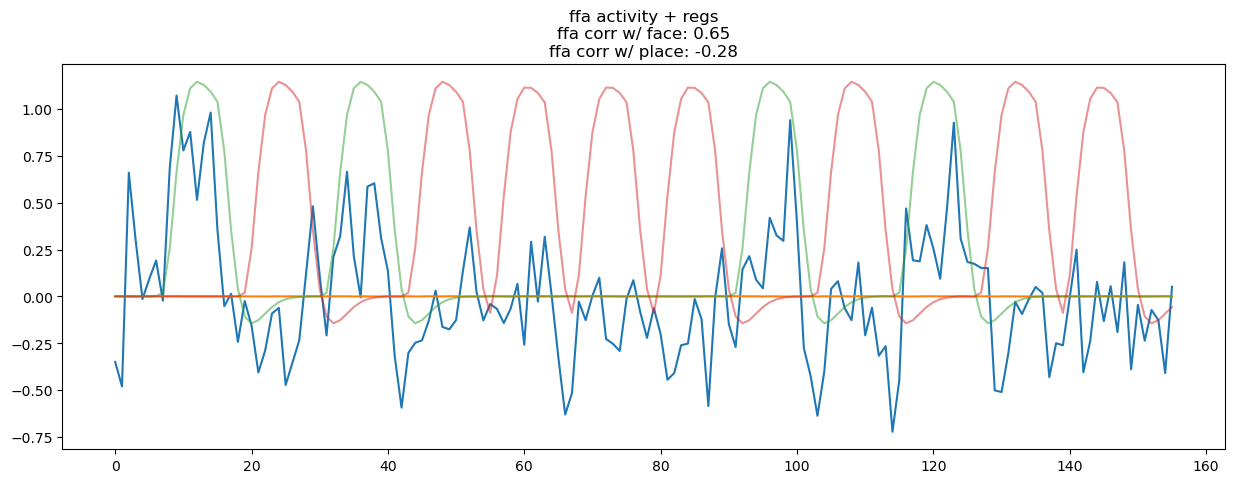

In [24]:
# Task regressors

from nilearn.glm.first_level import make_first_level_design_matrix
import pandas as pd

events_fn = f'../Data/StudyForrest/events/{sub}_ses-localizer_task-objectcategories_run-{r}_events.tsv'
events = pd.read_csv(events_fn,delimiter='\t')

t_r = 2.0 
n_scans = epi_flat.shape[1]  # the acquisition comprises 128 scans
frame_times = (np.arange(n_scans) * t_r)

X1 = make_first_level_design_matrix(frame_times,events,drift_model="polynomial",drift_order=3,hrf_model="SPM") #

#face_reg = X1['face'].values
#place_reg = X1[['body', 'house', 'object', 'scene', 'scramble']].values.sum(axis=1)

face_reg = X1[['face','body']].values.sum(axis=1)
place_reg = X1[['house', 'object', 'scene', 'scramble']].values.sum(axis=1)

ffa_im = ants.image_read(f'../Data/StudyForrest/ROIs/rFFA_final_mask_{sub}_bin.nii.gz')
func_ffa = func_gm[ffa_im.numpy().flatten()[gm_flat==1]==1,:]
ffa_scaler = Scaler(func_ffa)
ffa_list = ffa_scaler.transform(func_ffa)

plt.figure(figsize=(15,5))
plt.plot(ffa_list[:,:].mean(axis=0))
plt.plot(func_cf.mean(axis=0)-func_cf.mean(axis=0).mean())
plt.plot(face_reg,alpha=.5)
plt.plot(place_reg,alpha=.5)
plt.title('ffa activity + regs\n'+'ffa corr w/ face: {:.2f}\nffa corr w/ place: {:.2f}'.format(np.corrcoef(ffa_list[:,:].mean(axis=0),face_reg)[0,1],np.corrcoef(ffa_list[:,:].mean(axis=0),place_reg)[0,1]))

In [25]:
# Correlation between FFA AVG and regressors before denoising
(np.corrcoef(func_ffa.mean(axis=0),face_reg)[0,1],
np.corrcoef(func_ffa.mean(axis=0),place_reg)[0,1],)

(0.6811797051203488, -0.28804092063973524)

In [26]:
# Same thing, but correlate with every voxel first and then average the correlations. 
(np.array([np.corrcoef(func_ffa[v,:],face_reg)[0,1] for v in range(func_ffa.shape[0])]).mean(),
np.array([np.corrcoef(func_ffa[v,:],place_reg)[0,1] for v in range(func_ffa.shape[0])]).mean(),)

(0.22289404028398707, -0.09696170076272337)

In [27]:
def generate_correlated_fmri_noise(length, num_voxels, 
                                   phys_noise_level=0.1, 
                                   motion_noise_level=0.1, 
                                   drift_noise_level=0.05, 
                                   low_freq_noise_level=0.02, 
                                   correlation=0.5, 
                                   seed=None):
    """
    Generates correlated fMRI noise for multiple voxels.
    
    Parameters:
    length (int): Length of the time series (e.g., number of time points in the fMRI scan).
    num_voxels (int): Number of voxels (i.e., how many correlated noise vectors you want).
    phys_noise_level (float): Magnitude of physiological noise (e.g., respiratory and cardiac noise).
    motion_noise_level (float): Magnitude of motion-related noise.
    drift_noise_level (float): Magnitude of scanner drift noise (low-frequency drift).
    low_freq_noise_level (float): Magnitude of general low-frequency noise.
    correlation (float): Desired correlation between noise vectors (between 0 and 1).
    seed (int, optional): Random seed for reproducibility.

    Returns:
    np.ndarray: A matrix of shape (num_voxels, length) with correlated noise for each voxel.
    """
    
    if seed is not None:
        np.random.seed(seed)
    
    # Generate uncorrelated noise for each voxel
    noise_matrix = np.zeros((num_voxels, length))

    for i in tqdm(range(num_voxels)):
        # Generate physiological noise
        phys_noise = phys_noise_level * np.sin(np.linspace(0, 10 * np.pi, length)) * np.random.randn(length)
        
        # Generate motion-related noise (random spikes in signal)
        motion_noise = np.zeros(length)
        for _ in range(int(motion_noise_level * 10)):  # Random number of motion artifacts
            idx = np.random.randint(0, length-5)
            motion_noise[idx:idx+5] = np.random.randn(5) * motion_noise_level  # Add small burst of motion artifact
        
        # Generate low-frequency drift (scanner drift or baseline shift)
        drift_noise = drift_noise_level * np.polyval(np.random.randn(2), np.linspace(-1, 1, length))
        
        # General low-frequency noise (slow oscillations)
        low_freq_noise = low_freq_noise_level * np.sin(np.linspace(0, 2 * np.pi, length)) * np.random.randn(length)
        
        # Combine noise components for each voxel
        noise_matrix[i, :] = phys_noise + motion_noise + drift_noise + low_freq_noise
    
    # Create a correlation matrix
    corr_matrix = np.full((num_voxels, num_voxels), correlation) + np.eye(num_voxels) * (1 - correlation)
    
    # Cholesky decomposition to apply the correlation
    cholesky_decomp = np.linalg.cholesky(corr_matrix)
    
    # Apply the correlation structure to the noise matrix
    correlated_noise = np.dot(cholesky_decomp, noise_matrix)
    
    return correlated_noise





from scipy import signal
from scipy.stats import gamma

def spm_hrf(tr, length=32, peak_delay=6, undershoot_delay=16, peak_disp=1, undershoot_disp=1, ratio=6, scale=1.0):
    """
    Generates a hemodynamic response function (HRF) similar to the SPM canonical HRF.

    Parameters:
    tr (float): Repetition time (TR) of the fMRI scan (in seconds).
    length (float): Length of the HRF (in seconds).
    peak_delay (float): Time to the peak of the HRF (in seconds).
    undershoot_delay (float): Time to the undershoot of the HRF (in seconds).
    peak_disp (float): Dispersion of the peak.
    undershoot_disp (float): Dispersion of the undershoot.
    ratio (float): Ratio of the peak to the undershoot.
    scale (float): Scaling factor for the HRF.

    Returns:
    np.ndarray: The HRF vector sampled at intervals of the TR.
    """
    # Time points at which to evaluate the HRF
    t = np.arange(0, length, tr)
    
    # Gamma function for the peak and undershoot
    peak = gamma.pdf(t, peak_delay / peak_disp, scale=peak_disp)
    undershoot = gamma.pdf(t, undershoot_delay / undershoot_disp, scale=undershoot_disp)
    
    # HRF is the sum of the peak and undershoot components
    hrf = peak - undershoot / ratio
    
    # Normalize and scale the HRF
    hrf /= np.max(hrf)
    hrf *= scale
    
    return hrf

def simulate_voxel_response(boxcar, tr, hrf=None):
    """
    Simulates a voxel response to a task by convolving a boxcar task design with an HRF.
    
    Parameters:
    boxcar (np.ndarray): A binary vector (1=task on, 0=task off) representing the task design.
    tr (float): Repetition time (TR) of the fMRI scan (in seconds).
    hrf (np.ndarray, optional): A custom HRF. If None, a default SPM-like HRF will be used.
    
    Returns:
    np.ndarray: The simulated voxel response (BOLD signal).
    """
    # If no HRF is provided, use a default SPM-like HRF
    if hrf is None:
        hrf = spm_hrf(tr)
    
    # Convolve the boxcar with the HRF to generate the voxel response
    response = signal.convolve(boxcar, hrf)[:len(boxcar)]
    
    return response



def get_gt():
    # Example usage:
    tr = .8  # Repetition time of 2 seconds
    duration = 370  # Number of time points
    boxcar = np.zeros(duration)
    #ons = np.random.randint(low=0,high=300)
    ons = np.random.choice([50,150,250])
    boxcar[ons:ons+100] = 1  # Task "on" from time points 10 to 30
    #boxcar[200:250] = 1  # Task "on" again from time points 50 to 70
    
    # Simulate voxel response
    voxel_response = simulate_voxel_response(boxcar, tr)
    return voxel_response


In [28]:
do_synth_data = False
# Set to True to use simulated data. 
if do_synth_data==True:
    num_voxels = 12_500
    noise_matrix = generate_correlated_fmri_noise(length=370, num_voxels=num_voxels, 
                                                  phys_noise_level=0.2, motion_noise_level=0.1, 
                                                  drift_noise_level=0.05, correlation=0.5, seed=42)
    
    
    #gound_truth = np.array([get_gt()*.01 for _ in range(num_voxels)]) # Small effect size 
    gound_truth = np.array([get_gt()*.1 for _ in range(num_voxels)]) # Big effect size 
    
    func_cf = noise_matrix 
    func_gm = noise_matrix+gound_truth
    
    func_cf = func_cf*240 # Scale it to what BOLD signal is usually at
    func_gm = func_gm*240
    brain_gm = func_gm

    ## Induce overlap
    func_cf[0:2_500] = func_gm[10_000:12_500,:] # Make some CF voxels contain signal
    func_gm = func_gm[0:10_000,:] 
    func_cf = func_cf[0:10_000,:]
    gound_truth = gound_truth[0:10_000]
    brain_gm = func_gm 

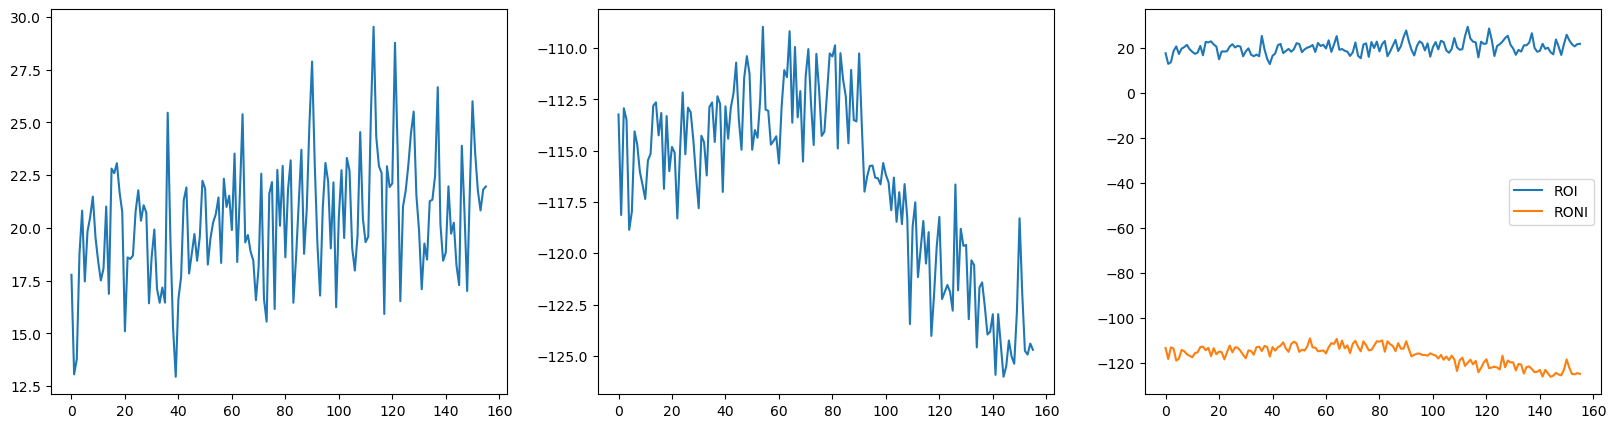

In [29]:
# Plot first voxel in ROI, RONI and both
plt.figure(figsize=(20,5))
plt.subplot(1,3,1);plt.plot(func_gm[0,:])
plt.subplot(1,3,2);plt.plot(func_cf[0,:])
plt.subplot(1,3,3);plt.plot(func_gm[0,:]);plt.plot(func_cf[0,:]);plt.legend(['ROI','RONI'])

In [30]:
print(func_gm.shape)
print(func_cf.shape)

(44212, 156)
(9519, 156)


In [31]:
#Normalization of Data, remove voxels with std of 0 so it doesnt crash CVAE (from Yu Zhu's code)
func_gm = remove_std0(func_gm)
func_cf = remove_std0(func_cf)
print(func_gm.shape)
print(func_cf.shape)

(44212, 156)
(9519, 156)


In [32]:
# Apply scaler to ROI and RONI
obs_scale = Scaler(func_gm)
obs_list = obs_scale.transform(func_gm)
print(obs_list.shape)
noi_scale = Scaler(func_cf)
noi_list = noi_scale.transform(func_cf)
print(noi_list.shape)

(44212, 156)
(9519, 156)


(array([4.00000e+00, 1.90000e+01, 4.57000e+02, 6.78550e+04, 7.43081e+05,
        6.26451e+05, 4.66660e+04, 4.05000e+02, 2.30000e+01, 3.00000e+00]),
 array([-8.702579  , -6.9408684 , -5.179158  , -3.4174483 , -1.6557382 ,
         0.10597181,  1.8676819 ,  3.629392  ,  5.391102  ,  7.152812  ,
         8.914522  ], dtype=float32),
 <BarContainer object of 10 artists>)

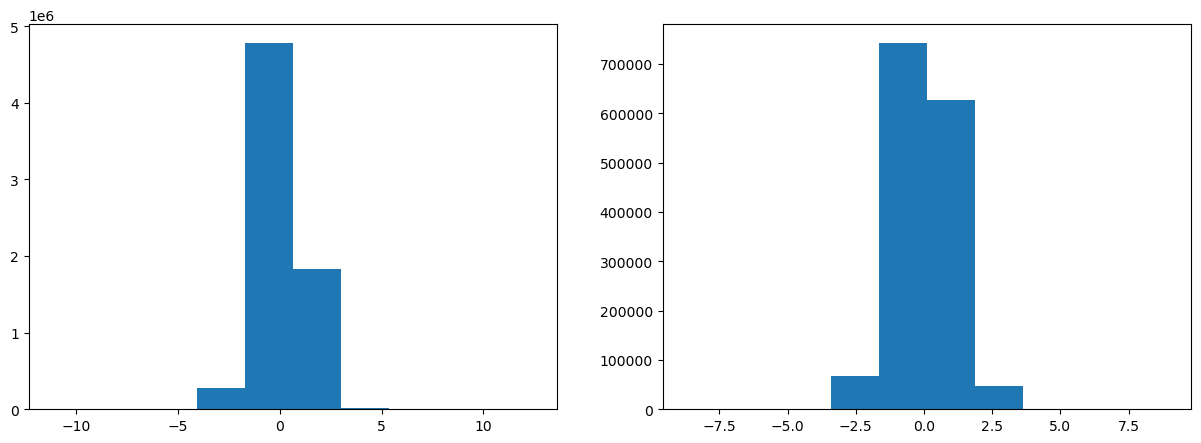

In [33]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(obs_list.flatten())
plt.subplot(1,2,2)
plt.hist(noi_list.flatten())

In [34]:
def norm(mat):
    return (mat - mat.min()) / ( mat.max()-mat.min() )

In [35]:
min_obs_list = obs_list.min()
max_obs_list = obs_list.max()

min_noi_list = noi_list.min()
max_noi_list = noi_list.max()

In [36]:
do_norm = False
# Optiomal, additionaly norm the inputs to be 0-1
if do_norm==True:
    obs_list = norm(obs_list)
    noi_list = norm(noi_list)

### DASHBOARD FUNCS

In [37]:
import sys
from IPython import display

In [38]:
def plot_r_w_reg():
    # plots correlation with regressors over time
    corr_w_reg = np.array(track['corr_w_reg'])
    c_ffa_bold_facereg = corr_w_reg[:,0]
    c_ffa_bold_placereg = corr_w_reg[:,1]
    c_ffa_bold_diff = corr_w_reg[:,2]
    c_tg_bold_facereg = corr_w_reg[:,3]
    c_tg_bold_placereg = corr_w_reg[:,4]
    c_tg_bold_diff = corr_w_reg[:,5]
    c_fg_bold_facereg = corr_w_reg[:,6]
    c_fg_bold_placereg = corr_w_reg[:,7]
    c_fg_bold_diff = corr_w_reg[:,8]
    c_bg_bold_facereg = corr_w_reg[:,9]
    c_bg_bold_placereg = corr_w_reg[:,10]
    c_bg_bold_diff = corr_w_reg[:,11]
    
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    plt.plot(c_ffa_bold_diff)
    plt.plot(c_tg_bold_diff)
    plt.plot(c_fg_bold_diff)
    plt.plot(c_bg_bold_diff)
    plt.legend(['ffa','tg','fg','bg'])
    plt.title(f'Diff {c_fg_bold_diff[-1]:.2f}')
    
    plt.subplot(1,3,2)
    plt.plot(c_ffa_bold_facereg)
    plt.plot(c_tg_bold_facereg)
    plt.plot(c_fg_bold_facereg)
    plt.plot(c_bg_bold_facereg)
    plt.legend(['ffa','tg','fg','bg'])
    plt.title('Face Reg')
    
    plt.subplot(1,3,3)
    plt.plot(c_ffa_bold_placereg)
    plt.plot(c_tg_bold_placereg)
    plt.plot(c_fg_bold_placereg)
    plt.plot(c_bg_bold_placereg)
    plt.legend(['ffa','tg','fg','bg'])
    plt.title('Place Reg')

In [39]:
def show_voxel_recon():
    # Shows voxel reconstructions
    plt.figure(figsize=(15,5))
    plt.plot( inputs_gm.detach().cpu().numpy()[:,0,:][0,:] )
    plt.plot( outputs_gm_tg.detach().cpu().numpy()[:,0,:][0,:] )
    plt.plot( outputs_gm_fg.detach().cpu().numpy()[:,0,:][0,:] )
    plt.plot( outputs_gm_bg.detach().cpu().numpy()[:,0,:][0,:] )
    plt.legend(['inputs_gm','outputs_gm_tg','outputs_gm_fg','outputs_gm_bg'])
    plt.title('GM')
    
    
    plt.figure(figsize=(15,5))
    plt.plot( inputs_cf.detach().cpu().numpy()[:,0,:][0,:] )
    plt.plot( outputs_cf_tg.detach().cpu().numpy()[:,0,:][0,:] )
    plt.plot( outputs_cf_fg.detach().cpu().numpy()[:,0,:][0,:] )
    plt.plot( outputs_cf_bg.detach().cpu().numpy()[:,0,:][0,:] )
    plt.legend(['inputs_cf','outputs_cf_tg','outputs_cf_fg','outputs_cf_bg'])
    plt.title('CF')


In [40]:
def show_dashboard():
    # Dashboard plotting losses 
    
    plt.figure(figsize=(20,10))
    plt.subplot(3,4,1)
    plt.plot(running_loss_L);plt.title(f'running_loss_L: {running_loss_L[-1]:.4f}')
    
    plt.subplot(3,4,2)
    plt.plot(running_recons_L);plt.title(f'running_recons_L: {running_recons_L[-1]:.4f}')
    
    plt.subplot(3,4,3)
    plt.plot(running_recons_roi_L);plt.title(f'running_recons_roi_L: {running_recons_roi_L[-1]:.4f}')
    
    plt.subplot(3,4,4)
    plt.plot(running_recons_roni_L);plt.title(f'running_recons_roni_L: {running_recons_roni_L[-1]:.4f}')
    
    
    plt.subplot(3,4,5)
    plt.plot(running_KLD_L);plt.title(f'running_KLD_L: {running_KLD_L[-1]:.4f}')
    
    plt.subplot(3,4,6)
    plt.plot(running_TC_L);plt.title(f'running_TC_L: {running_TC_L[-1]:.4f}')
    
    plt.subplot(3,4,7)
    plt.plot(running_recons_discourage_L);plt.title(f'running_recons_discourage_L: {running_recons_discourage_L[-1]:.4f}')
    
    plt.subplot(3,4,8)
    plt.plot(track['TG-BG-SL-RSA']);plt.title('RSA: {:.4f}'.format(track['TG-BG-SL-RSA'][-1]))
    
    plt.subplot(3,4,9)
    plt.plot(running_VOL_L);plt.title(f'running_VOL_L: {running_VOL_L[-1]:.4f}')
    
    plt.subplot(3,4,10)
    plt.plot(running_recons_FG_L);plt.title(f'running_recons_FG_L: {running_recons_FG_L[-1]:.4f}')
    
    plt.subplot(3,4,11)
    plt.plot(running_recons_roi_L[-10::]);plt.title(f'running_recons_roi_L (last 10): {running_recons_roi_L[-1]:.4f}')
    
    plt.subplot(3,4,12)
    plt.plot(track['varexp-gm'])
    plt.plot(track['varexp-cf'])
    plt.plot(track['varexp-fg'])
    plt.legend(['varexp-gm','varexp-cf','varexp-fg'])
    plt.title('var exp')


In [41]:
def show_ffa_dashboard():
    # Plots FFA, reconstructions and correlations with regressors
    ffa_batch = ffa_list[0:batch_size,:]
    ffa_batch = torch.tensor(ffa_batch[:,np.newaxis,:]).to(device)
    
    ffa_tg = model.forward_tg(ffa_batch)
    ffa_tg = ffa_tg[0].detach().cpu().numpy()[:,0,:]
    
    ffa_fg = model.forward_fg(ffa_batch)
    ffa_fg = ffa_fg[0].detach().cpu().numpy()[:,0,:]
    
    ffa_bg = model.forward_bg(ffa_batch)
    ffa_bg = ffa_bg[0].detach().cpu().numpy()[:,0,:]
    
    plt.figure(figsize=(15,3))
    plt.subplot(1,4,1)
    plt.plot(ffa_list[:,:].mean(axis=0))
    plt.plot(noi_list.mean(axis=0))
    plt.plot(face_reg)
    plt.plot(place_reg)
    
    c = np.corrcoef(ffa_list[:,:].mean(axis=0),face_reg)[0,1]
    plt.title(f'ffa activity + regs: {c:.2f}')
    
    plt.subplot(1,4,2)
    plt.plot(ffa_tg[:,:].mean(axis=0))
    plt.plot(face_reg*ffa_tg[:,:].mean(axis=0).max(),alpha=.5)
    #plt.plot(place_reg*ffa_tg[:,:].mean(axis=0).max())
    c = np.corrcoef(ffa_tg[:,:].mean(axis=0),face_reg)[0,1]
    plt.title(f'ffa TG + regs {c:.2f}')
    
    plt.subplot(1,4,3)
    plt.plot(ffa_fg[:,:].mean(axis=0))
    plt.plot(face_reg*ffa_fg[:,:].mean(axis=0).max(),alpha=.5)
    #plt.plot(place_reg*ffa_fg[:,:].mean(axis=0).max())
    c = np.corrcoef(ffa_fg[:,:].mean(axis=0),face_reg)[0,1]
    plt.title(f'ffa FG + regs {c:.2f}')
    
    plt.subplot(1,4,4)
    plt.plot(ffa_bg[:,:].mean(axis=0))
    plt.plot(face_reg*ffa_bg[:,:].mean(axis=0).max(),alpha=.5)
    #plt.plot(place_reg*ffa_bg[:,:].mean(axis=0).max())
    c = np.corrcoef(ffa_bg[:,:].mean(axis=0),face_reg)[0,1]
    plt.title(f'ffa BG + regs {c:.2f}')
    plt.tight_layout()

In [42]:
contrast_vals = []

def get_betas(ffa_batch):
    # Calculates betas for different regressors
    Y = ffa_batch
    do_norm=True # This is important, incase DeepCor scales the signal, we dont want the betas to be artificailly inflated
    if do_norm==True:
        Y = Y-Y.mean(axis=1)[:,np.newaxis]
        Y = Y/Y.std(axis=1)[:,np.newaxis]
    Y = Y.T
    X = X1.values # Regressor information 
    beta = np.linalg.inv(X.T @ X1) @ X1.T @ Y
    beta = beta.T
    return beta
    
def get_contrast(ffa_fg):
    # Calculates face+body > house+scene+object+scramble
    beta = get_betas(ffa_fg).values
    contrast_vector = np.array([2,2,-1,-1,-1,-1,0,0,0,0])
    contrast_values = beta @ contrast_vector
    return contrast_values.mean()
    
def show_contrast_dash():
    # Plots contrast values over time
    ffa_batch = ffa_list[0:batch_size,:]
    ffa_batch = torch.tensor(ffa_batch[:,np.newaxis,:]).to(device)
    
    ffa_tg = model.forward_tg(ffa_batch)
    ffa_tg = ffa_tg[0].detach().cpu().numpy()[:,0,:]
    
    ffa_fg = model.forward_fg(ffa_batch)
    ffa_fg = ffa_fg[0].detach().cpu().numpy()[:,0,:]
    
    ffa_bg = model.forward_bg(ffa_batch)
    ffa_bg = ffa_bg[0].detach().cpu().numpy()[:,0,:]
    
    ffa_batch = ffa_list[0:batch_size,:]

    conf_pcs = PCA(n_components=5).fit_transform(epi_flat[cf_flat==1,:].transpose())
    conf_pcs.shape
    
    lin_reg = linear_model.LinearRegression()
    lin_reg.fit(conf_pcs,ffa_batch.transpose());
    ffa_compcorr = ffa_batch.transpose()-lin_reg.predict(conf_pcs)
    ffa_compcorr = ffa_compcorr.transpose()
    
    contrast_vals.append([get_contrast(ffa_batch),
    get_contrast(ffa_compcorr),
    get_contrast(ffa_tg),
    get_contrast(ffa_fg),
    get_contrast(ffa_bg),])
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(get_betas(ffa_batch).mean(axis=0),'b.',markersize=20,alpha=.5);
    plt.plot(get_betas(ffa_compcorr).mean(axis=0),'k.',markersize=20,alpha=.5);
    plt.plot(get_betas(ffa_tg).mean(axis=0),'y.',markersize=20,alpha=.5);
    plt.plot(get_betas(ffa_fg).mean(axis=0),'g.',markersize=20,alpha=.5);
    plt.plot(get_betas(ffa_bg).mean(axis=0),'r.',markersize=20,alpha=.5);
    plt.legend(['BOLD','COMPCOR','TG','FG','BG']);
    plt.xticks(np.arange(X1.shape[-1]),labels=list(X1.columns),rotation=45);
    plt.title('betas')
    
    plt.subplot(1,2,2)
    plt.plot(np.array(contrast_vals)[:,0],'b-')
    plt.plot(np.array(contrast_vals)[:,1],'k-')
    plt.plot(np.array(contrast_vals)[:,2],'y-')
    plt.plot(np.array(contrast_vals)[:,3],'g-')
    plt.plot(np.array(contrast_vals)[:,4],'r-')
    plt.legend(['BOLD','COMPCOR','TG','FG','BG'],loc='lower left');
    plt.title('Contrast')

In [43]:
# Pretraining Loop
from datetime import datetime
timestamp = "{:%Y_%m_%d_%H_%M_%S}".format(datetime.now())
pretrain_dir = f'pretraining-{sub}-R{r}-T-{timestamp}' # pretraining dir is {sub}-{run}-{timestamp}
print(pretrain_dir)
safe_mkdir(os.path.join('../Data/StudyForrest/pretraining',pretrain_dir)) # Makes the directory

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

n_repetitions = 5
n_epochs_per_rep = 20
for j in tqdm(np.arange(0,n_repetitions)):

    # Hyperparameters
    batch_size = 1024
    latent_dim = (256,256) # Shared,Specific
    beta = 0.0001       
    gamma = 0 # TC scaling
    delta = 100 # "Denoised RONI should be zero" scaling
    scale_MSE_GM = 1e3 # Scale ROI loss 
    scale_MSE_CF = 1e4 # Scale RONI loss
    scale_MSE_FG = 1 # "Denoised should be similar to input" scaling
    disentangle_type = 2

    ## Use this code to randomly sample hyperparameters during pretraining
    # latent_dim = (256,256)
    # gamma = 100
    # scale_MSE_FG = 1
    # batch_size = int(random.choice([256,512,1024]))
    # latent_dim = random.choice([(16,16),(8,24),(24,8)])
    # beta = random.choice([0.0001,0.00001,0.000001,0.000001])
    # gamma = random.choice([0,0.01,0.1,0.2,0.5,1,2,5])
    # delta = random.choice([0,1e2,2e2,5e2,1e3,2e3])
    # scale_MSE_GM = random.choice([1e1,1e1,2e1,1e3,2e3])
    # scale_MSE_CF = random.choice([1e1,1e1,2e1,1e3,2e3])
    # scale_MSE_FG = random.choice([-100,-10,0,10,100])

    train_inputs,train_in,model,discriminator,optimizer = [],[],[],[],[]
    del train_inputs,train_in,model,discriminator,optimizer
    
    torch.cuda.empty_cache()
    torch.cuda.init()
    
    # Pre-training
    # DataLoader
    train_inputs = TrainDataset(obs_list,noi_list)
    
    # dataloading 
    train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,
                                                 shuffle=True, num_workers=1,drop_last=True)
    
    # cVAE model
    Tensor = TypeVar('torch.tensor')
    
    model = cVAE(1,func_cf.shape[1],latent_dim, beta=beta, gamma=gamma,delta=delta,scale_MSE_GM=scale_MSE_GM,scale_MSE_CF=scale_MSE_CF,scale_MSE_FG=scale_MSE_FG,do_disentangle=True,disentangle_type=2)
    
    #model.apply(custom_weight_init)
    discriminator = Discriminator(sum(latent_dim))
    model.to(device)
    discriminator.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
    optimizer_discrim = optim.AdamW(discriminator.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
    
    epoch_num = n_epochs_per_rep
    for epoch in range(epoch_num):  # loop over the dataset multiple times    
        dataloader_iter_in = iter(train_in)
        
        
        for i in range(len(train_in)):
            
            optimizer_discrim.zero_grad()
            optimizer.zero_grad()


            inputs_gm,inputs_cf = next(dataloader_iter_in)
            inputs_gm = inputs_gm.unsqueeze(1).float().to(device)
            inputs_cf = inputs_cf.unsqueeze(1).float().to(device)

            if disentangle_type==1: # Update Discriminator
                with torch.no_grad():
                    outputs_tg = model.forward_tg(inputs_gm)
                    _, _, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s, tg_z, tg_s = outputs_tg
    
                    
                qz_s = torch.cat([tg_z.detach(), tg_s.detach()], dim=1)
                z_perm = tg_z.detach()[torch.randperm(tg_z.size(0))]
                s_perm = tg_s.detach()[torch.randperm(tg_s.size(0))]
                qz_s_perm = torch.cat([z_perm, s_perm], dim=1)
                
                optimizer_discrim.zero_grad()
                joint_logits = discriminator(qz_s)
                factorized_logits = discriminator(qz_s_perm)
                labels_joint = torch.ones_like(joint_logits)
                labels_factorized = torch.zeros_like(factorized_logits)
                d_loss = F.binary_cross_entropy_with_logits(joint_logits, labels_joint) + F.binary_cross_entropy_with_logits(factorized_logits, labels_factorized)
                d_loss.backward()
                optimizer_discrim.step()


            ## Update CVAE
            [outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s] = model.forward_tg(inputs_gm)
            [outputs_cf, inputs_cf, bg_mu_z, bg_log_var_z] = model.forward_bg(inputs_cf)
            
            outputs = torch.concat((outputs_gm,outputs_cf),1)
            loss = model.loss_function(outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s, outputs_cf, inputs_cf, bg_mu_z, bg_log_var_z)
 
            if np.isnan(loss['loss'].detach().cpu().numpy()):
                print('loss is NaN')
                break

            loss['loss'].backward()
            optimizer.step()
            
    
        if np.isnan(loss['loss'].detach().cpu().numpy()):
                print('loss is NaN')
                break
    track = {}
    track['iter'] = j
    
    track['batch_size'] = batch_size
    track['latent_dim1'] = latent_dim[0]
    track['latent_dim2'] = latent_dim[1]
    track['beta'] = beta
    track['gamma'] = gamma
    track['delta'] = delta
    track['scale_MSE_GM'] = scale_MSE_GM
    track['scale_MSE_CF'] = scale_MSE_CF
    track['scale_MSE_FG'] = scale_MSE_FG
    
    track['loss'] = loss['loss'].detach().cpu().numpy()
    track['KLD'] = loss['KLD'].detach().cpu().numpy()
    track['total_contrastive_loss'] = loss['total_contrastive_loss'].detach().cpu().numpy()
    track['recons_loss_roni'] = loss['recons_loss_roni'].detach().cpu().numpy()
    track['recons_loss_roi'] = loss['recons_loss_roi'].detach().cpu().numpy()
    track['recons_loss_discourage'] = loss['recons_loss_discourage'].detach().cpu().numpy()
    track['recons_loss_fg'] = loss['recons_loss_fg'].detach().cpu().numpy()
    
    ffa_batch = ffa_list[0:batch_size,:]
    ffa_batch = torch.tensor(ffa_batch[:,np.newaxis,:]).to(device)
    
    ffa_tg = model.forward_tg(ffa_batch)
    ffa_tg = ffa_tg[0].detach().cpu().numpy()[:,0,:]
    
    ffa_fg = model.forward_fg(ffa_batch)
    ffa_fg = ffa_fg[0].detach().cpu().numpy()[:,0,:]
    
    ffa_bg = model.forward_bg(ffa_batch)
    ffa_bg = ffa_bg[0].detach().cpu().numpy()[:,0,:]
    
    ffa_batch = ffa_batch.detach().cpu().numpy()[:,0,:]
    
    ffa_vec = ffa_batch.mean(axis=0)
    ffa_bg_vec = ffa_bg.mean(axis=0)
    ffa_tg_vec = ffa_tg.mean(axis=0)
    ffa_fg_vec = ffa_fg.mean(axis=0)
    
    track['r_tg_fg'] = np.corrcoef(ffa_tg_vec,ffa_fg_vec)[0,1]
    track['r_tg_bg'] = np.corrcoef(ffa_tg_vec,ffa_bg_vec)[0,1]
    track['r_fg_bg'] = np.corrcoef(ffa_fg_vec,ffa_bg_vec)[0,1]

    track['r_ffa_fg'] = np.corrcoef(ffa_vec,ffa_fg_vec)[0,1]
    track['r_ffa_bg'] = np.corrcoef(ffa_vec,ffa_bg_vec)[0,1]
    track['r_ffa_bg'] = np.corrcoef(ffa_vec,ffa_bg_vec)[0,1]
    
    track['corr2face_ffa'] = np.corrcoef(face_reg,ffa_vec)[0,1]
    track['corr2face_tg'] = np.corrcoef(face_reg,ffa_tg_vec)[0,1]
    track['corr2face_fg'] = np.corrcoef(face_reg,ffa_fg_vec)[0,1]
    track['corr2face_bg'] = np.corrcoef(face_reg,ffa_bg_vec)[0,1]
    
    track['corr2place_ffa'] = np.corrcoef(place_reg,ffa_vec)[0,1]
    track['corr2place_tg'] = np.corrcoef(place_reg,ffa_tg_vec)[0,1]
    track['corr2place_fg'] = np.corrcoef(place_reg,ffa_fg_vec)[0,1]
    track['corr2place_bg'] = np.corrcoef(place_reg,ffa_bg_vec)[0,1]
    
    track['con_face_ffa'] = get_contrast(ffa_batch)
    track['con_face_tg'] = get_contrast(ffa_tg)
    track['con_face_fg'] = get_contrast(ffa_fg)
    track['con_face_bg'] = get_contrast(ffa_bg)
    
    SS_total = ((ffa_batch-ffa_batch.mean(axis=0))**2).sum()
    SS_model = ((ffa_batch-ffa_tg)**2).sum()
    track['varexp_tg'] = 1-(SS_model/SS_total)
    
    SS_model = ((ffa_batch-ffa_fg)**2).sum()
    track['varexp_fg'] = 1-(SS_model/SS_total)
    
    SS_model = ((ffa_batch-ffa_bg)**2).sum()
    track['varexp_bg'] = 1-(SS_model/SS_total)
    
    # track['input-gm-tg-corr'] = correlate_columns(inputs_gm.cpu().detach().numpy()[:,0,:].transpose(),model.forward_tg(inputs_gm)[0].cpu().detach().numpy()[:,0,:].transpose()).mean()
    # track['input-gm-bg-corr'] = correlate_columns(inputs_gm.cpu().detach().numpy()[:,0,:].transpose(),model.forward_bg(inputs_gm)[0].cpu().detach().numpy()[:,0,:].transpose()).mean()
    # track['input-gm-fg-corr'] = correlate_columns(inputs_gm.cpu().detach().numpy()[:,0,:].transpose(),model.forward_fg(inputs_gm)[0].cpu().detach().numpy()[:,0,:].transpose()).mean()
    # track['input-cf-tg-corr'] = correlate_columns(inputs_cf.cpu().detach().numpy()[:,0,:].transpose(),model.forward_tg(inputs_cf)[0].cpu().detach().numpy()[:,0,:].transpose()).mean()
    # track['input-cf-bg-corr'] = correlate_columns(inputs_cf.cpu().detach().numpy()[:,0,:].transpose(),model.forward_bg(inputs_cf)[0].cpu().detach().numpy()[:,0,:].transpose()).mean()
    # track['input-cf-fg-corr'] = correlate_columns(inputs_cf.cpu().detach().numpy()[:,0,:].transpose(),model.forward_fg(inputs_cf)[0].cpu().detach().numpy()[:,0,:].transpose()).mean()
    
    # track['input-gm-tg-rsa'] = np.corrcoef(get_triu(make_RDM(inputs_gm.cpu().detach().numpy()[:,0,:],metric='correlation')),get_triu(make_RDM(model.forward_tg(inputs_gm)[0].cpu().detach().numpy()[:,0,:],metric='correlation')))[0,1]
    # track['input-gm-bg-rsa'] = np.corrcoef(get_triu(make_RDM(inputs_gm.cpu().detach().numpy()[:,0,:],metric='correlation')),get_triu(make_RDM(model.forward_bg(inputs_gm)[0].cpu().detach().numpy()[:,0,:],metric='correlation')))[0,1]
    # track['input-gm-fg-rsa'] = np.corrcoef(get_triu(make_RDM(inputs_gm.cpu().detach().numpy()[:,0,:],metric='correlation')),get_triu(make_RDM(model.forward_fg(inputs_gm)[0].cpu().detach().numpy()[:,0,:],metric='correlation')))[0,1]
    # track['input-cf-tg-rsa'] = np.corrcoef(get_triu(make_RDM(inputs_cf.cpu().detach().numpy()[:,0,:],metric='correlation')),get_triu(make_RDM(model.forward_tg(inputs_cf)[0].cpu().detach().numpy()[:,0,:],metric='correlation')))[0,1]
    # track['input-cf-bg-rsa'] = np.corrcoef(get_triu(make_RDM(inputs_cf.cpu().detach().numpy()[:,0,:],metric='correlation')),get_triu(make_RDM(model.forward_bg(inputs_cf)[0].cpu().detach().numpy()[:,0,:],metric='correlation')))[0,1]
    # track['input-cf-fg-rsa'] = np.corrcoef(get_triu(make_RDM(inputs_cf.cpu().detach().numpy()[:,0,:],metric='correlation')),get_triu(make_RDM(model.forward_fg(inputs_cf)[0].cpu().detach().numpy()[:,0,:],metric='correlation')))[0,1]

    track['corrDiff_tg_ffa'] = track['corr2face_tg']-track['corr2face_ffa']
    track['corrDiff_fg_tg'] = track['corr2face_fg']-track['corr2face_tg']
    
    track['conDiff_tg_ffa'] = track['con_face_tg']-track['con_face_ffa']
    track['conDiff_fg_tg'] = track['con_face_fg']-track['con_face_tg']
    
    keys = list(track.keys())
    df = pd.DataFrame(np.array([float(track[key]) for key in keys])[np.newaxis,:],columns=keys)
    df.to_csv(f'../Data/StudyForrest/pretraining/{pretrain_dir}/pretrain-{sub}-iter-{j}.csv')

    torch.save(model.state_dict(),f'../Data/StudyForrest/pretraining/{pretrain_dir}/cvae_weights-{sub}-iter-{j}.weights')
    torch.save(discriminator.state_dict(),f'../Data/StudyForrest/pretraining/{pretrain_dir}/discriminator_weights-{sub}-iter-{j}.weights')

pretraining-sub-02-R1-T-2025_01_02_22_21_09


  0%|                                                     | 0/5 [00:11<?, ?it/s]


UnboundLocalError: local variable 'mu' referenced before assignment

In [ ]:
# Gets all the pretraining files
indir = f'../Data/StudyForrest/pretraining/{pretrain_dir}'
files = [f for f in os.listdir(indir) if f.startswith('pretrain')]
files.sort()

In [ ]:
# Combine the pretraining information
dfs = [pd.read_csv(os.path.join(indir,file)) for file in files]
df = pd.concat(dfs)
df.to_csv(os.path.join(indir,'group.csv'))

In [ ]:
# Score the pretraining according to variance explained and correlation between the spaces
pd.options.display.max_columns = None
v1=df['varexp_tg'].values
v2=1-abs(df['r_fg_bg'].values)
score = np.vstack([v1,v2]).mean(axis=0)
df['score'] = score
df.sort_values(by='score',ascending=False)

In [ ]:
# pd.options.display.max_columns = None
# v1=df['varexp_tg'].values
# v2=1-abs(df['con_face_ffa'].values)
# v3=df['corr2place_fg'].values
# score = np.vstack([v1,v2]).mean(axis=0)
# df['score'] = score
# df.sort_values(by='score',ascending=False)

In [ ]:
# Sort pretraining by score and select the top one for further training

pretrain_number = df.sort_values(by='score',ascending=False)['iter'].values[0]
weights_fn_cvae = f'../Data/StudyForrest/pretraining/{pretrain_dir}/cvae_weights-{sub}-iter-{int(pretrain_number)}.weights'
weights_fn_discrim = f'../Data/StudyForrest/pretraining/{pretrain_dir}/discriminator_weights-{sub}-iter-{int(pretrain_number)}.weights'

assert os.path.exists(weights_fn_cvae)
assert os.path.exists(weights_fn_discrim)

In [ ]:
df_sorted = df.sort_values(by='score',ascending=False)
n = df_sorted.shape[0]

In [ ]:
# Show pretraining values, selected one is in green
plt.figure(figsize=(10,15))

keys = ['varexp_tg',
        'varexp_bg',
        'varexp_fg',
        'r_tg_fg',
        'r_tg_bg',
        'r_fg_bg',
        'total_contrastive_loss',
     'recons_loss_roni',
     'recons_loss_roi',
     'recons_loss_discourage',
        'recons_loss_fg',
        'corrDiff_tg_ffa',
 'corrDiff_fg_tg',
 'conDiff_tg_ffa',
 'conDiff_fg_tg',]
for i in range(len(keys)):
    plt.subplot(3,5,i+1)
    xs = np.repeat(1,n)
    plt.plot(xs[1::],df_sorted[keys[i]].values[1::],'k.')
    plt.plot(xs[0],df_sorted[keys[i]].values[0],'g.',markersize=20,alpha=.5)
    plt.title(keys[i])

plt.tight_layout()

## INIT and RUN model

In [ ]:
# batch_size = 1024
# latent_dim = (64,64)
# beta = 0.00001
# gamma = 0
# delta = 100
# scale_MSE_GM = 1e3
# scale_MSE_CF = 1e4
# scale_MSE_FG = 0

In [ ]:
# DataLoader
train_inputs = TrainDataset(obs_list,noi_list)

# dataloading 
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,
                                             shuffle=True, num_workers=1,drop_last=True)
Tensor = TypeVar('torch.tensor')
# Init models
model = cVAE(1,func_cf.shape[1],latent_dim, beta=beta, gamma=gamma,delta=delta,scale_MSE_GM=scale_MSE_GM,scale_MSE_CF=scale_MSE_CF,scale_MSE_FG=scale_MSE_FG,do_disentangle=True,disentangle_type=1)
discriminator = Discriminator(sum(latent_dim))

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
optimizer_discrim = optim.AdamW(discriminator.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
discriminator.to(device)

epoch_num = 1_000

In [ ]:
# Load the pretraining weights
model.load_state_dict(torch.load(weights_fn_cvae, weights_only=True))
discriminator.load_state_dict(torch.load(weights_fn_discrim, weights_only=True))

In [ ]:
# Initialize tracking variables
running_loss_L = []
running_recons_L = []
running_recons_roi_L = []
running_recons_roni_L = []
running_recons_FG_L = []
running_recons_discourage_L = []
running_KLD_L = []
running_TC_L = []
running_VOL_L = []

track = {}

track['cmat_bg'] = []
track['cmat_cf'] = []

track['synth-GM-GT-TG'] = []
track['synth-GM-GT-FG'] = []
track['synth-GM-GT-BG'] = []

track['synth-CF-GT-TG'] = []
track['synth-CF-GT-FG'] = []
track['synth-CF-GT-BG'] = []

track['TG-BG-SL-RSA'] = []
track['corr_w_reg'] = []

track['input-gm-tg-corr'] = []
track['input-gm-bg-corr'] = []
track['input-gm-fg-corr'] = []
track['input-cf-tg-corr'] = []
track['input-cf-bg-corr'] = []
track['input-cf-fg-corr'] = []

track['input-gm-tg-rsa'] = []
track['input-gm-bg-rsa'] = []
track['input-gm-fg-rsa'] = []
track['input-cf-tg-rsa'] = []
track['input-cf-bg-rsa'] = []
track['input-cf-fg-rsa'] = []

track['varexp-gm'] = []
track['varexp-cf'] = []
track['varexp-fg'] = []

In [ ]:
# MAIN TRAINING LOOP
for epoch in tqdm(range(epoch_num)):
    running_loss = 0.0
    running_reconstruction_loss = 0.0
    running_reconstruction_loss_roi = 0.0
    running_reconstruction_loss_roni = 0.0
    running_reconstruction_loss_FG = 0.0
    running_reconstruction_loss_discourage = 0.0
    running_KLD = 0.0
    running_TC = 0.0
    running_VOL = 0.0

    track['epoch-input-gm-tg-corr'] = []
    track['epoch-input-gm-bg-corr'] = []
    track['epoch-input-gm-fg-corr'] = []
    track['epoch-input-cf-tg-corr'] = []
    track['epoch-input-cf-bg-corr'] = []
    track['epoch-input-cf-fg-corr'] = []

    track['epoch-input-gm-tg-rsa'] = []
    track['epoch-input-gm-bg-rsa'] = []
    track['epoch-input-gm-fg-rsa'] = []
    track['epoch-input-cf-tg-rsa'] = []
    track['epoch-input-cf-bg-rsa'] = []
    track['epoch-input-cf-fg-rsa'] = []

    # Iterate over data.
    dataloader_iter_in = iter(train_in)
    for i in range(len(train_in)):
        inputs_gm,inputs_cf = next(dataloader_iter_in)

        inputs_gm = inputs_gm.unsqueeze(1).float().to(device)
        inputs_cf = inputs_cf.unsqueeze(1).float().to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        
    # Update Discriminator
        with torch.no_grad():
            outputs_tg = model.forward_tg(inputs_gm)
            _, _, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s, tg_z, tg_s = outputs_tg

            
        qz_s = torch.cat([tg_z.detach(), tg_s.detach()], dim=1)
        z_perm = tg_z.detach()[torch.randperm(tg_z.size(0))]
        s_perm = tg_s.detach()[torch.randperm(tg_s.size(0))]
        qz_s_perm = torch.cat([z_perm, s_perm], dim=1)
        
        optimizer_discrim.zero_grad()
        joint_logits = discriminator(qz_s)
        factorized_logits = discriminator(qz_s_perm)
        labels_joint = torch.ones_like(joint_logits)
        labels_factorized = torch.zeros_like(factorized_logits)
        d_loss = F.binary_cross_entropy_with_logits(joint_logits, labels_joint) + F.binary_cross_entropy_with_logits(factorized_logits, labels_factorized)
        d_loss.backward()
        optimizer_discrim.step()

        # encoder + decoder
        #[outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x] = model.forward_tg(inputs_gm)
        [outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s] = model.forward_tg(inputs_gm)
        
        #[outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s] = model.forward_bg(inputs_cf)
        [outputs_cf, inputs_cf, bg_mu_z, bg_log_var_z] = model.forward_bg(inputs_cf)
        
        outputs = torch.concat((outputs_gm,outputs_cf),1)
        loss = model.loss_function(outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s, outputs_cf, inputs_cf, bg_mu_z, bg_log_var_z)
        assert ~np.isnan(loss['loss'].detach().cpu().numpy()), print(loss) ; 'loss is NaN'
        loss['loss'].backward()
        optimizer.step()

        
        running_loss += loss['loss']
        running_reconstruction_loss += loss['Reconstruction_Loss']
        running_reconstruction_loss_roi += loss['recons_loss_roi']
        running_reconstruction_loss_roni += loss['recons_loss_roni'] 
        running_reconstruction_loss_FG += loss['recons_loss_fg'] 
        running_reconstruction_loss_discourage += loss['recons_loss_discourage']
        running_KLD += loss['KLD']   
        running_TC += loss['total_contrastive_loss'].detach()  
        running_VOL += loss['fg_volatility_loss']  
        

        track['epoch-input-gm-tg-corr'].append( correlate_columns(inputs_gm.cpu().detach().numpy()[:,0,:].transpose(),model.forward_tg(inputs_gm)[0].cpu().detach().numpy()[:,0,:].transpose()).mean() )
        track['epoch-input-gm-bg-corr'].append( correlate_columns(inputs_gm.cpu().detach().numpy()[:,0,:].transpose(),model.forward_bg(inputs_gm)[0].cpu().detach().numpy()[:,0,:].transpose()).mean() )
        track['epoch-input-gm-fg-corr'].append( correlate_columns(inputs_gm.cpu().detach().numpy()[:,0,:].transpose(),model.forward_fg(inputs_gm)[0].cpu().detach().numpy()[:,0,:].transpose()).mean() )
        track['epoch-input-cf-tg-corr'].append( correlate_columns(inputs_cf.cpu().detach().numpy()[:,0,:].transpose(),model.forward_tg(inputs_cf)[0].cpu().detach().numpy()[:,0,:].transpose()).mean() )
        track['epoch-input-cf-bg-corr'].append( correlate_columns(inputs_cf.cpu().detach().numpy()[:,0,:].transpose(),model.forward_bg(inputs_cf)[0].cpu().detach().numpy()[:,0,:].transpose()).mean() )
        track['epoch-input-cf-fg-corr'].append( correlate_columns(inputs_cf.cpu().detach().numpy()[:,0,:].transpose(),model.forward_fg(inputs_cf)[0].cpu().detach().numpy()[:,0,:].transpose()).mean() )

        track['epoch-input-gm-tg-rsa'].append( np.corrcoef(get_triu(make_RDM(inputs_gm.cpu().detach().numpy()[:,0,:],metric='correlation')),get_triu(make_RDM(model.forward_tg(inputs_gm)[0].cpu().detach().numpy()[:,0,:],metric='correlation')))[0,1] )
        track['epoch-input-gm-bg-rsa'].append( np.corrcoef(get_triu(make_RDM(inputs_gm.cpu().detach().numpy()[:,0,:],metric='correlation')),get_triu(make_RDM(model.forward_bg(inputs_gm)[0].cpu().detach().numpy()[:,0,:],metric='correlation')))[0,1] )
        track['epoch-input-gm-fg-rsa'].append( np.corrcoef(get_triu(make_RDM(inputs_gm.cpu().detach().numpy()[:,0,:],metric='correlation')),get_triu(make_RDM(model.forward_fg(inputs_gm)[0].cpu().detach().numpy()[:,0,:],metric='correlation')))[0,1] )
        track['epoch-input-cf-tg-rsa'].append( np.corrcoef(get_triu(make_RDM(inputs_cf.cpu().detach().numpy()[:,0,:],metric='correlation')),get_triu(make_RDM(model.forward_tg(inputs_cf)[0].cpu().detach().numpy()[:,0,:],metric='correlation')))[0,1] )
        track['epoch-input-cf-bg-rsa'].append( np.corrcoef(get_triu(make_RDM(inputs_cf.cpu().detach().numpy()[:,0,:],metric='correlation')),get_triu(make_RDM(model.forward_bg(inputs_cf)[0].cpu().detach().numpy()[:,0,:],metric='correlation')))[0,1] )
        track['epoch-input-cf-fg-rsa'].append( np.corrcoef(get_triu(make_RDM(inputs_cf.cpu().detach().numpy()[:,0,:],metric='correlation')),get_triu(make_RDM(model.forward_fg(inputs_cf)[0].cpu().detach().numpy()[:,0,:],metric='correlation')))[0,1] )



    track['input-gm-tg-corr'].append(np.array(track['epoch-input-gm-tg-corr']).mean())
    track['input-gm-bg-corr'].append(np.array(track['epoch-input-gm-bg-corr']).mean())
    track['input-gm-fg-corr'].append(np.array(track['epoch-input-gm-fg-corr']).mean())
    track['input-cf-tg-corr'].append(np.array(track['epoch-input-cf-tg-corr']).mean())
    track['input-cf-bg-corr'].append(np.array(track['epoch-input-cf-bg-corr']).mean())
    track['input-cf-fg-corr'].append(np.array(track['epoch-input-cf-fg-corr']).mean())

    track['input-gm-tg-rsa'].append(np.array(track['epoch-input-gm-tg-rsa']).mean())
    track['input-gm-bg-rsa'].append(np.array(track['epoch-input-gm-bg-rsa']).mean())
    track['input-gm-fg-rsa'].append(np.array(track['epoch-input-gm-fg-rsa']).mean())
    track['input-cf-tg-rsa'].append(np.array(track['epoch-input-cf-tg-rsa']).mean())
    track['input-cf-bg-rsa'].append(np.array(track['epoch-input-cf-bg-rsa']).mean())
    track['input-cf-fg-rsa'].append(np.array(track['epoch-input-cf-fg-rsa']).mean())
    
    track['TG-BG-SL-RSA'].append( np.corrcoef(get_triu(make_RDM(tg_mu_s.detach().cpu().numpy())),get_triu(make_RDM(tg_mu_z.detach().cpu().numpy())))[0,1] )
    
    outputs_gm_tg = model.forward_tg(inputs_gm)[0]
    outputs_gm_fg = model.forward_fg(inputs_gm)[0]
    outputs_gm_bg = model.forward_bg(inputs_gm)[0]
    
    outputs_cf_tg = model.forward_tg(inputs_cf)[0]
    outputs_cf_fg = model.forward_fg(inputs_cf)[0]
    outputs_cf_bg = model.forward_bg(inputs_cf)[0]

    SS_model = ((inputs_gm.detach().cpu().numpy()[:,0,:]-outputs_gm.detach().cpu().numpy()[:,0,:])**2).sum()
    SS_total = ((inputs_gm.detach().cpu().numpy()[:,0,:]-inputs_gm.detach().cpu().numpy()[:,0,:].mean(axis=0))**2).sum()
    varexp_gm = 1-(SS_model/SS_total)
    
    SS_model = ((inputs_cf.detach().cpu().numpy()[:,0,:]-outputs_cf.detach().cpu().numpy()[:,0,:])**2).sum()
    SS_total = ((inputs_cf.detach().cpu().numpy()[:,0,:]-outputs_cf.detach().cpu().numpy()[:,0,:].mean(axis=0))**2).sum()
    varexp_cf = 1-(SS_model/SS_total)
    
    SS_model = ((inputs_gm.detach().cpu().numpy()[:,0,:]-outputs_gm_fg.detach().cpu().numpy()[:,0,:])**2).sum()
    SS_total = ((inputs_gm.detach().cpu().numpy()[:,0,:]-inputs_gm.detach().cpu().numpy()[:,0,:].mean(axis=0))**2).sum()
    varexp_fg = 1-(SS_model/SS_total)

    track['varexp-gm'].append(varexp_gm)
    track['varexp-cf'].append(varexp_cf)
    track['varexp-fg'].append(varexp_fg)

    cmat_bg = np.array([(np.corrcoef(np.array((inputs_gm.detach().cpu().numpy()[:,0,:][v,:],
outputs_gm_tg.detach().cpu().numpy()[:,0,:][v,:],
outputs_gm_fg.detach().cpu().numpy()[:,0,:][v,:],
outputs_gm_bg.detach().cpu().numpy()[:,0,:][v,:])))) for v in range(inputs_gm.shape[0])]).mean(axis=0)

    cmat_cf = np.array([(np.corrcoef(np.array((inputs_cf.detach().cpu().numpy()[:,0,:][v,:],
outputs_cf_tg.detach().cpu().numpy()[:,0,:][v,:],
outputs_cf_fg.detach().cpu().numpy()[:,0,:][v,:],
outputs_cf_bg.detach().cpu().numpy()[:,0,:][v,:])))) for v in range(inputs_gm.shape[0])]).mean(axis=0)

    track['cmat_bg'].append(cmat_bg)
    track['cmat_cf'].append(cmat_cf)

    if do_synth_data==True:
        
        probe = torch.tensor(obs_list[0:64,np.newaxis,:]).float().to(device)

        recon_probe_tg = model.forward_tg(probe)[0]
        recon_probe_fg = model.forward_fg(probe)[0]
        recon_probe_bg = model.forward_bg(probe)[0]
        
        track['synth-GM-GT-TG'].append( correlate_columns(recon_probe_tg.detach().cpu().numpy()[:,0,:].transpose(),gound_truth[0:64,:].transpose()).mean() )
        track['synth-GM-GT-FG'].append( correlate_columns(recon_probe_fg.detach().cpu().numpy()[:,0,:].transpose(),gound_truth[0:64,:].transpose()).mean() )
        track['synth-GM-GT-BG'].append( correlate_columns(recon_probe_bg.detach().cpu().numpy()[:,0,:].transpose(),gound_truth[0:64,:].transpose()).mean() ) 
        
        probe = torch.tensor(noi_list[0:64,np.newaxis,:]).float().to(device)
        
        recon_probe_tg = model.forward_tg(probe)[0]
        recon_probe_fg = model.forward_fg(probe)[0]
        recon_probe_bg = model.forward_bg(probe)[0]
        
        track['synth-CF-GT-TG'].append( correlate_columns(recon_probe_tg.detach().cpu().numpy()[:,0,:].transpose(),gound_truth[0:64,:].transpose()).mean() )
        track['synth-CF-GT-FG'].append( correlate_columns(recon_probe_fg.detach().cpu().numpy()[:,0,:].transpose(),gound_truth[0:64,:].transpose()).mean() )
        track['synth-CF-GT-BG'].append( correlate_columns(recon_probe_bg.detach().cpu().numpy()[:,0,:].transpose(),gound_truth[0:64,:].transpose()).mean() ) 

    epoch_running_loss = running_loss / (len(train_in)*2)
    epoch_running_reconstruction_loss = running_reconstruction_loss / (len(train_in)*2)
    running_reconstruction_loss_roi = running_reconstruction_loss_roi / (len(train_in)*2)
    running_reconstruction_loss_roni = running_reconstruction_loss_roni / (len(train_in)*2)
    running_reconstruction_loss_FG = running_reconstruction_loss_FG / (len(train_in)*2)
    running_reconstruction_loss_discourage = running_reconstruction_loss_discourage / (len(train_in)*2)

    epoch_running_KLD = running_KLD / (len(train_in)*2)
    epoch_running_TC = running_TC / (len(train_in)*2)
    running_VOL = running_VOL / (len(train_in)*2)
    
    running_loss_L.append(epoch_running_loss.cpu().detach().numpy())
    running_recons_L.append(epoch_running_reconstruction_loss.cpu().detach().numpy())
    running_KLD_L.append(epoch_running_KLD.cpu().detach().numpy())
    running_TC_L.append(epoch_running_TC.cpu().detach().numpy())
    running_recons_roi_L.append(running_reconstruction_loss_roi.cpu().detach().numpy())
    running_recons_roni_L.append(running_reconstruction_loss_roni.cpu().detach().numpy())
    running_recons_FG_L.append(running_reconstruction_loss_FG.cpu().detach().numpy())
    running_recons_discourage_L.append( running_reconstruction_loss_discourage.cpu().detach().numpy() )
    running_VOL_L.append( running_VOL.cpu().detach().numpy() )
    track['corr_w_reg'].append(get_corr_w_reg())

    # DASHBOARD
    if np.mod(epoch,10)==0:
        plt.close()
        sys.stdout.flush()
        display.clear_output(wait=True);
        display.display(plt.gcf());
    
        plot_r_w_reg();plt.show()
        show_dashboard();plt.show()
        show_ffa_dashboard();plt.show()
        show_contrast_dash();plt.show()
        show_voxel_recon();plt.show()
        #plt.tight_layout()
        plt.show()

In [ ]:
if do_synth_data==False:
    
    ffa_batch = ffa_list[0:batch_size,:]
    ffa_batch = torch.tensor(ffa_batch[:,np.newaxis,:]).to(device)
    
    ffa_tg = model.forward_tg(ffa_batch)
    ffa_tg = ffa_tg[0].detach().cpu().numpy()[:,0,:]
    
    ffa_fg = model.forward_fg(ffa_batch)
    ffa_fg = ffa_fg[0].detach().cpu().numpy()[:,0,:]
    
    ffa_bg = model.forward_bg(ffa_batch)
    ffa_bg = ffa_bg[0].detach().cpu().numpy()[:,0,:]
    
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.plot(ffa_list[:,:].mean(axis=0))
    plt.plot(noi_list.mean(axis=0))
    plt.plot(face_reg)
    plt.plot(place_reg)
    
    c = np.corrcoef(ffa_list[:,:].mean(axis=0),face_reg)[0,1]
    plt.title(f'ffa activity + regs: {c:.2f}')
    
    plt.subplot(2,2,2)
    plt.plot(ffa_tg[:,:].mean(axis=0))
    plt.plot(face_reg*ffa_tg[:,:].mean(axis=0).max())
    plt.plot(place_reg*ffa_tg[:,:].mean(axis=0).max())
    c = np.corrcoef(ffa_tg[:,:].mean(axis=0),face_reg)[0,1]
    plt.title(f'ffa TG + regs {c:.2f}')
    
    plt.subplot(2,2,3)
    plt.plot(ffa_fg[:,:].mean(axis=0))
    plt.plot(face_reg*ffa_fg[:,:].mean(axis=0).max())
    plt.plot(place_reg*ffa_fg[:,:].mean(axis=0).max())
    c = np.corrcoef(ffa_fg[:,:].mean(axis=0),face_reg)[0,1]
    plt.title(f'ffa FG + regs {c:.2f}')
    
    plt.subplot(2,2,4)
    plt.plot(ffa_bg[:,:].mean(axis=0))
    plt.plot(face_reg*ffa_bg[:,:].mean(axis=0).max())
    plt.plot(place_reg*ffa_bg[:,:].mean(axis=0).max())
    c = np.corrcoef(ffa_bg[:,:].mean(axis=0),face_reg)[0,1]
    plt.title(f'ffa BG + regs {c:.2f}')

In [ ]:
if do_synth_data==False:
    
    ffa_batch = ffa_list[0:batch_size,:]
    ffa_batch = torch.tensor(ffa_batch[:,np.newaxis,:]).to(device)
    
    ffa_tg = model.forward_tg(ffa_batch)
    ffa_tg = ffa_tg[0].detach().cpu().numpy()[:,0,:]
    
    ffa_fg = model.forward_fg(ffa_batch)
    ffa_fg = ffa_fg[0].detach().cpu().numpy()[:,0,:]
    
    ffa_bg = model.forward_bg(ffa_batch)
    ffa_bg = ffa_bg[0].detach().cpu().numpy()[:,0,:]
    
    plt.figure(figsize=(30,5))
    plt.subplot(1,4,1)
    plt.plot(ffa_list[:,:].mean(axis=0))
    #plt.plot(noi_list.mean(axis=0))
    plt.plot(face_reg)
    #plt.plot(place_reg)
    
    c = np.corrcoef(ffa_list[:,:].mean(axis=0),face_reg)[0,1]
    plt.title(f'FFA activity and face+body regs: r={c:.2f}')
    
    plt.subplot(1,4,2)
    plt.plot(ffa_tg[:,:].mean(axis=0))
    plt.plot(face_reg*ffa_tg[:,:].mean(axis=0).max())
    #plt.plot(place_reg*ffa_tg[:,:].mean(axis=0).max())
    c = np.corrcoef(ffa_tg[:,:].mean(axis=0),face_reg)[0,1]
    plt.title(f'FFA DeepCor reconstruction and face+body regs: r={c:.2f}')
    
    plt.subplot(1,4,3)
    plt.plot(ffa_fg[:,:].mean(axis=0))
    plt.plot(face_reg*ffa_fg[:,:].mean(axis=0).max())
    #plt.plot(place_reg*ffa_fg[:,:].mean(axis=0).max())
    c = np.corrcoef(ffa_fg[:,:].mean(axis=0),face_reg)[0,1]
    plt.title(f'FFA DeepCor denoised and face+body regs: r={c:.2f}')
    
    plt.subplot(1,4,4)
    plt.plot(ffa_bg[:,:].mean(axis=0))
    plt.plot(face_reg*ffa_bg[:,:].mean(axis=0).max())
    #plt.plot(place_reg*ffa_bg[:,:].mean(axis=0).max())
    c = np.corrcoef(ffa_bg[:,:].mean(axis=0),face_reg)[0,1]
    plt.title(f'FFA DeepCor noise and face+body regs: r={c:.2f}')

In [ ]:
# plt.plot(X1['face'].values)
# plt.plot(X1['body'].values)

In [ ]:
v1 = ffa_tg[:,:].mean(axis=0)
v2 = ffa_fg[:,:].mean(axis=0)
v3=ffa_batch.detach().cpu().numpy()[:,0,:].mean(axis=0)

v1=v1-v1.mean()
v2=v2-v2.mean()
v3=v3-v3.mean()
v1 = v1/v1.std()
v2 = v2/v2.std()
v3 = v3/v3.std()
plt.plot(v1)
plt.plot(v2)
plt.plot(v3)

In [ ]:
#plt.plot(ffa_list[:,:].mean(axis=0))
#plt.plot(noi_list.mean(axis=0))
#plt.plot(noi_list.mean(axis=0))
#plt.plot(face_reg*ffa_tg[:,:].mean(axis=0).max())
plt.figure(figsize=(15,5))
plt.plot(ffa_list[:,:].mean(axis=0))
plt.plot(ffa_tg[:,:].mean(axis=0))
plt.plot(ffa_fg[:,:].mean(axis=0))
plt.plot(ffa_bg[:,:].mean(axis=0))
plt.plot(face_reg*ffa_tg[:,:].mean(axis=0).max())

In [ ]:
if do_synth_data==False:
    corr_w_reg = np.array(track['corr_w_reg'])
    #corr_w_reg.shape
    
    c_ffa_bold_facereg = corr_w_reg[:,0]
    c_ffa_bold_placereg = corr_w_reg[:,1]
    c_ffa_bold_diff = corr_w_reg[:,2]
    c_tg_bold_facereg = corr_w_reg[:,3]
    c_tg_bold_placereg = corr_w_reg[:,4]
    c_tg_bold_diff = corr_w_reg[:,5]
    c_fg_bold_facereg = corr_w_reg[:,6]
    c_fg_bold_placereg = corr_w_reg[:,7]
    c_fg_bold_diff = corr_w_reg[:,8]
    c_bg_bold_facereg = corr_w_reg[:,9]
    c_bg_bold_placereg = corr_w_reg[:,10]
    c_bg_bold_diff = corr_w_reg[:,11]
    
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    plt.plot(c_ffa_bold_diff)
    plt.plot(c_tg_bold_diff)
    plt.plot(c_fg_bold_diff)
    plt.plot(c_bg_bold_diff)
    plt.legend(['ffa','tg','fg','bg'])
    plt.title(f'Diff {c_fg_bold_diff[-1]:.2f}')
    
    plt.subplot(1,3,2)
    plt.plot(c_ffa_bold_facereg)
    plt.plot(c_tg_bold_facereg)
    plt.plot(c_fg_bold_facereg)
    plt.plot(c_bg_bold_facereg)
    plt.legend(['ffa','tg','fg','bg'])
    plt.title('Face Reg')
    
    plt.subplot(1,3,3)
    plt.plot(c_ffa_bold_placereg)
    plt.plot(c_tg_bold_placereg)
    plt.plot(c_fg_bold_placereg)
    plt.plot(c_bg_bold_placereg)
    plt.legend(['ffa','tg','fg','bg'])
    plt.title('Place Reg')

In [ ]:
if do_synth_data==True:
    plt.figure(figsize=(15,5))
    v = 0
    probe = torch.tensor(obs_list[v:v+batch_size,np.newaxis,:]).float().to(device)
    recon_probe_tg = model.forward_tg(probe)[0]
    recon_probe_fg = model.forward_fg(probe)[0]
    recon_probe_bg = model.forward_bg(probe)[0]
    
    v1=norm(probe.detach().cpu().numpy()[:,0,:][v,:]); plt.plot(v1,alpha=.5,linewidth=3)
    v2=norm(recon_probe_tg.detach().cpu().numpy()[:,0,:][v,:]);plt.plot(v2,alpha=.5,linewidth=3)
    v3=norm(recon_probe_fg.detach().cpu().numpy()[:,0,:][v,:]);plt.plot(v3,alpha=.5,linewidth=3)
    v4=norm(recon_probe_bg.detach().cpu().numpy()[:,0,:][v,:]);plt.plot(v4,alpha=.5,linewidth=3)
    v5=norm(gound_truth[v,:]); plt.plot(v5,alpha=.5,linewidth=3)
    
    plt.legend([f'input: {np.corrcoef(v1,v5)[0,1]:.2f}',f'recon_probe_tg: {np.corrcoef(v2,v5)[0,1]:.2f}',f'recon_probe_fg {np.corrcoef(v3,v5)[0,1]:.2f}',f'recon_probe_bg: {np.corrcoef(v4,v5)[0,1]:.2f}','ground-truth'])

In [ ]:
#plt.imshow(np.corrcoef(inputs_gm.detach().cpu().numpy()[:,0,:],inputs_cf.detach().cpu().numpy()[:,0,:]))

In [ ]:
outputs_gm_tg = model.forward_tg(inputs_gm)[0]
outputs_gm_fg = model.forward_fg(inputs_gm)[0]
outputs_gm_bg = model.forward_bg(inputs_gm)[0]

outputs_cf_tg = model.forward_tg(inputs_cf)[0]
outputs_cf_fg = model.forward_fg(inputs_cf)[0]
outputs_cf_bg = model.forward_bg(inputs_cf)[0]

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.heatmap(np.array([(np.corrcoef(np.array((inputs_gm.detach().cpu().numpy()[:,0,:][v,:],
outputs_gm_tg.detach().cpu().numpy()[:,0,:][v,:],
outputs_gm_fg.detach().cpu().numpy()[:,0,:][v,:],
outputs_gm_bg.detach().cpu().numpy()[:,0,:][v,:])))) for v in range(inputs_gm.shape[0])]).mean(axis=0),annot=True,xticklabels=['Input','BG+SL','0+SL','BG+0'],
            yticklabels=['Input','BG+SL','0+SL','BG+0'])

plt.title('ROI')

plt.subplot(1,2,2)
sns.heatmap(np.array([(np.corrcoef(np.array((inputs_cf.detach().cpu().numpy()[:,0,:][v,:],
outputs_cf_tg.detach().cpu().numpy()[:,0,:][v,:],
outputs_cf_fg.detach().cpu().numpy()[:,0,:][v,:],
outputs_cf_bg.detach().cpu().numpy()[:,0,:][v,:])))) for v in range(inputs_gm.shape[0])]).mean(axis=0),annot=True,xticklabels=['Input','BG+SL','0+SL','BG+0'],
            yticklabels=['Input','BG+SL','0+SL','BG+0'])

plt.title('RONI')

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(np.array(track['cmat_bg'])[:,0,1]))
plt.plot(np.array(np.array(track['cmat_bg'])[:,0,2]),linewidth=5)
plt.plot(np.array(np.array(track['cmat_bg'])[:,0,3]))
plt.plot(np.array(np.array(track['cmat_bg'])[:,1,2]))
plt.plot(np.array(np.array(track['cmat_bg'])[:,1,3]))
plt.plot(np.array(np.array(track['cmat_bg'])[:,2,3]))
plt.legend(['input:BG+SL', 'input:0+SL','input:BG+0','BG+SL:0+SL','BG+SL:0+SL','0+SL:0+BG'])

plt.subplot(1,2,2)
plt.plot(np.array(np.array(track['cmat_cf'])[:,0,1]))
plt.plot(np.array(np.array(track['cmat_cf'])[:,0,2]))
plt.plot(np.array(np.array(track['cmat_cf'])[:,0,3]),linewidth=5)
plt.plot(np.array(np.array(track['cmat_cf'])[:,1,2]))
plt.plot(np.array(np.array(track['cmat_cf'])[:,1,3]))
plt.plot(np.array(np.array(track['cmat_cf'])[:,2,3]))
plt.legend(['input:BG+SL', 'input:0+SL','input:BG+0','BG+SL:0+SL','BG+SL:0+SL','0+SL:0+BG'])

In [ ]:
plt.plot(track['varexp-gm'])
plt.plot(track['varexp-cf'])
plt.plot(track['varexp-fg'])
plt.legend(['varexp-gm','varexp-cf','varexp-fg'])
plt.title('var exp')

In [ ]:
plt.figure(figsize=(15,5))
plt.plot( inputs_gm.detach().cpu().numpy()[:,0,:][0,:] )
plt.plot( outputs_gm_tg.detach().cpu().numpy()[:,0,:][0,:] )
plt.plot( outputs_gm_fg.detach().cpu().numpy()[:,0,:][0,:] )
plt.plot( outputs_gm_bg.detach().cpu().numpy()[:,0,:][0,:] )

plt.legend(['inputs_gm','outputs_gm_tg','outputs_gm_fg','outputs_gm_bg'])

In [ ]:
plt.figure(figsize=(15,5))
plt.plot( inputs_cf.detach().cpu().numpy()[:,0,:][0,:] )
plt.plot( outputs_cf_tg.detach().cpu().numpy()[:,0,:][0,:] )
plt.plot( outputs_cf_fg.detach().cpu().numpy()[:,0,:][0,:] )
plt.plot( outputs_cf_bg.detach().cpu().numpy()[:,0,:][0,:] )
plt.legend(['inputs_cf','outputs_cf_tg','outputs_cf_fg','outputs_cf_bg'])

In [ ]:
np.array([np.corrcoef(inputs_gm.cpu().detach().numpy()[:,0,:][v,:],outputs_gm.cpu().detach().numpy()[:,0,:][v,:])[0,1] for v in range(batch_size)]).mean()

In [ ]:
np.array([np.corrcoef(inputs_cf.cpu().detach().numpy()[:,0,:][v,:],outputs_cf.cpu().detach().numpy()[:,0,:][v,:])[0,1] for v in range(batch_size)]).mean()

In [ ]:
# plt.figure(figsize=(20,10))
# plt.subplot(3,4,1)
# plt.plot(running_loss_L);plt.title(f'running_loss_L: {running_loss_L[-1]:.4f}')

# plt.subplot(3,4,2)
# plt.plot(running_recons_L);plt.title(f'running_recons_L: {running_recons_L[-1]:.4f}')

# plt.subplot(3,4,3)
# plt.plot(running_recons_roi_L);plt.title(f'running_recons_roi_L: {running_recons_roi_L[-1]:.4f}')

# plt.subplot(3,4,4)
# plt.plot(running_recons_roni_L);plt.title(f'running_recons_roni_L: {running_recons_roni_L[-1]:.4f}')


# plt.subplot(3,4,5)
# plt.plot(running_KLD_L);plt.title(f'running_KLD_L: {running_KLD_L[-1]:.4f}')

# plt.subplot(3,4,6)
# plt.plot(running_TC_L);plt.title(f'running_TC_L: {running_TC_L[-1]:.4f}')

# plt.subplot(3,4,7)
# plt.plot(running_recons_discourage_L);plt.title(f'running_recons_discourage_L: {running_recons_discourage_L[-1]:.4f}')

# plt.subplot(3,4,8)
# plt.plot(track['TG-BG-SL-RSA']);plt.title('RSA: {:.4f}'.format(track['TG-BG-SL-RSA'][-1]))

# plt.subplot(3,4,9)
# plt.plot(running_VOL_L);plt.title(f'running_VOL_L: {running_VOL_L[-1]:.4f}')

# plt.subplot(3,4,10)
# plt.plot(running_recons_FG_L);plt.title(f'running_recons_FG_L: {running_recons_FG_L[-1]:.4f}')

# plt.subplot(3,4,11)
# plt.plot(running_recons_roi_L[-10::]);plt.title(f'running_recons_roi_L (last 10): {running_recons_roi_L[-1]:.4f}')

In [ ]:
   # track['input-gm-tg-corr'].append(np.array(track['epoch-input-gm-tg-corr']).mean())
   #  track['input-gm-bg-corr'].append(np.array(track['epoch-input-gm-bg-corr']).mean())
   #  track['input-gm-fg-corr'].append(np.array(track['epoch-input-gm-fg-corr']).mean())
   #  track['input-cf-tg-corr'].append(np.array(track['epoch-input-cf-tg-corr']).mean())
   #  track['input-cf-bg-corr'].append(np.array(track['epoch-input-cf-bg-corr']).mean())
   #  track['input-cf-fg-corr'].append(np.array(track['epoch-input-cf-fg-corr']).mean())

   #  track['input-gm-tg-rsa'].append(np.array(track['epoch-input-gm-tg-rsa']).mean())
   #  track['input-gm-bg-rsa'].append(np.array(track['epoch-input-gm-bg-rsa']).mean())
   #  track['input-gm-fg-rsa'].append(np.array(track['epoch-input-gm-fg-rsa']).mean())
   #  track['input-cf-tg-rsa'].append(np.array(track['epoch-input-cf-tg-rsa']).mean())
   #  track['input-cf-bg-rsa'].append(np.array(track['epoch-input-cf-bg-rsa']).mean())
   #  track['input-cf-fg-rsa'].append(np.array(track['epoch-input-cf-fg-rsa']).mean())

In [ ]:
keys = ['input-gm-tg-corr',
'input-gm-bg-corr',
'input-gm-fg-corr',
'input-cf-tg-corr',
'input-cf-bg-corr',
'input-cf-fg-corr',
'input-gm-tg-rsa',
'input-gm-bg-rsa',
'input-gm-fg-rsa',
'input-cf-tg-rsa',
'input-cf-bg-rsa',
'input-cf-fg-rsa',]

plt.figure(figsize=(20,15))
for i, key in enumerate(keys):
    plt.subplot(4,3,i+1)
    plt.plot(track[key]);plt.title(key+f': {track[key][-1]:.2f}')

plt.subplots_adjust()

In [ ]:
if do_synth_data==True:
    plt.figure(figsize=(20,10))
    plt.subplot(2,3,1);plt.plot(track['synth-GM-GT-TG']);plt.title('synth-GM-GT-TG')
    plt.subplot(2,3,2);plt.plot(track['synth-GM-GT-FG']);plt.title('synth-GM-GT-FG')
    plt.subplot(2,3,3);plt.plot(track['synth-GM-GT-BG']);plt.title('synth-GM-GT-BG')
    
    plt.subplot(2,3,4);plt.plot(track['synth-CF-GT-TG']);plt.title('synth-CF-GT-TG')
    plt.subplot(2,3,5);plt.plot(track['synth-CF-GT-FG']);plt.title('synth-CF-GT-FG')
    plt.subplot(2,3,6);plt.plot(track['synth-CF-GT-BG']);plt.title('synth-CF-GT-BG')

In [ ]:
# plt.figure(figsize=(20,10))
# for i,key in enumerate(track.keys()):
#     plt.subplot(2,3,i+1)
#     plt.plot(track[key])
#     plt.title(key)

# plt.subplots_adjust()

In [ ]:
# dataloader_iter_in = iter(train_in)
# inputs_gm,inputs_cf = next(dataloader_iter_in)
# inputs_gm = inputs_gm.unsqueeze(1).float().to(device)
# inputs_cf = inputs_cf.unsqueeze(1).float().to(device)
# [outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x] = model.forward_tg(inputs_gm)
# [outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s] = model.forward_bg(inputs_cf)

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
v1 = inputs_gm.detach().cpu().numpy()[0,0,:]
v2 = outputs_gm.detach().cpu().numpy()[0,0,:]

plt.plot(v1,alpha=.5)
plt.plot(v2,alpha=.5)
plt.title(f'GM in/out: corr: {np.corrcoef(v1,v2)[0,1]:.2f}')
plt.legend(['Input','Output'])

plt.subplot(1,2,2)
v1 = inputs_cf.detach().cpu().numpy()[0,0,:]
v2 = outputs_cf.detach().cpu().numpy()[0,0,:]

plt.plot(v1,alpha=.5)
plt.plot(v2,alpha=.5)
plt.legend(['Input','Output'])
plt.title(f'CF in/out: corr: {np.corrcoef(v1,v2)[0,1]:.2f}')

In [ ]:
brain_scaler = Scaler(brain_gm)
brain_list = brain_scaler.transform(brain_gm)

In [ ]:
#func_data = obs_list
def get_reconstructions(func_data,mode='TG'):
    
    denoise_inputs = DenoiseDataset(func_data)
    denoise_in = torch.utils.data.DataLoader(denoise_inputs, batch_size=512,shuffle=False, num_workers=1)
    denoise_iter_in = iter(denoise_in)
    
    for i in tqdm(range(len(denoise_in))):
        inputs = next(denoise_iter_in)
        inputs = inputs.unsqueeze(1).float().to(device)
        
        #func_output = model.generate(inputs)
        
        if mode=='TG':
            func_output = model.forward_tg(inputs)[0]
        elif mode=='BG':
            func_output = model.forward_bg(inputs)[0]
        elif mode=='FG':
            func_output = model.forward_fg(inputs)[0]
            
        func_output_np = func_output.squeeze().cpu().detach().numpy()
        if i == 0:
            outputs_all = func_output_np 
        else:
            outputs_all = np.concatenate((outputs_all,func_output_np), axis = 0)
    return outputs_all

In [ ]:
outputs_all_TG = get_reconstructions(brain_list,mode='TG')

In [ ]:
outputs_all_BG = get_reconstructions(brain_list,mode='BG')

In [ ]:
outputs_all_FG = get_reconstructions(brain_list,mode='FG')

In [ ]:
#plt.plot(epi_flat[gm_flat==1,:].mean(axis=0))

In [ ]:
#plt.plot(obs_scale.inverse_transform(outputs_all_TG)[gm_flat,:].mean(axis=0))

In [ ]:
if do_synth_data==True:
    outputs_all_TG = get_reconstructions(obs_list,mode='TG')
    outputs_all_BG = get_reconstructions(obs_list,mode='BG')
    outputs_all_FG = get_reconstructions(obs_list,mode='FG')

In [ ]:
v = 10000
plt.figure(figsize=(15,5))
plt.plot(outputs_all_TG[v,:],'b-',alpha=.5)
plt.plot(outputs_all_FG[v,:],'g-',alpha=.5)
plt.plot(outputs_all_BG[v,:],'r-',alpha=.5)
plt.legend(['TG','FG','BG'])

In [ ]:
func_data = brain_list
obs_scale = brain_scaler

v = 5000
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(func_data[v,:])
plt.plot(outputs_all_TG[v,:])
plt.legend(['func_data','outputs_all'])
plt.title(f'corr: {np.corrcoef(func_data[v,:],outputs_all_TG[v,:])[0,1]:.2f}')

plt.subplot(1,2,2)
plt.plot(brain_gm[v,:])

descaled = obs_scale.inverse_transform(outputs_all_TG)
if do_norm==True:
    descaled = obs_scale.inverse_transform(outputs_all_TG * (max_obs_list-min_obs_list) + min_obs_list)
plt.plot(descaled[v,:])
plt.title(f'corr: {np.corrcoef(brain_gm[v,:],descaled[v,:])[0,1]:.2f}')
plt.legend(['Raw in','Out inv-scaled'])
plt.suptitle('outputs_all_TG')


#v = 500
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(func_data[v,:])
plt.plot(outputs_all_BG[v,:])
plt.legend(['func_data','outputs_all'])
plt.title(f'corr: {np.corrcoef(func_data[v,:],outputs_all_BG[v,:])[0,1]:.2f}')

plt.subplot(1,2,2)
plt.plot(brain_gm[v,:])

descaled = obs_scale.inverse_transform(outputs_all_BG)
if do_norm==True:
    descaled = obs_scale.inverse_transform(outputs_all_BG * (max_obs_list-min_obs_list) + min_obs_list)
plt.plot(descaled[v,:])
plt.title(f'corr: {np.corrcoef(brain_gm[v,:],descaled[v,:])[0,1]:.2f}')
plt.legend(['Raw in','Out inv-scaled'])
plt.suptitle('outputs_all_BG')


#v = 500
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(func_data[v,:])
plt.plot(outputs_all_FG[v,:])
plt.legend(['func_data','outputs_all'])
plt.title(f'corr: {np.corrcoef(func_data[v,:],outputs_all_FG[v,:])[0,1]:.2f}')

plt.subplot(1,2,2)
plt.plot(brain_gm[v,:])

descaled = obs_scale.inverse_transform(outputs_all_FG)
if do_norm==True:
    descaled = obs_scale.inverse_transform(outputs_all_FG * (max_obs_list-min_obs_list) + min_obs_list)
plt.plot(descaled[v,:])
plt.title(f'corr: {np.corrcoef(func_data[v,:],descaled[v,:])[0,1]:.2f}')
plt.legend(['Raw in','Out inv-scaled'])
plt.suptitle('outputs_all_FG')

In [ ]:
#outdir = os.path.join('../Data/050-Data-DeepCor-ed',analysis_name)
outdir = os.path.join('../Data/StudyForrest/DeepCor-outputs/',analysis_name)
print(outdir)

In [ ]:
pwd

In [ ]:
safe_mkdir(outdir)

In [ ]:
if do_synth_data==False:
    
    denoised_flat = np.zeros(epi_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3,:] = obs_scale.inverse_transform(outputs_all_TG) # Takes into account std0 voxels
    denoised_mat = denoised_flat.reshape(epi.shape)
    denoised = epi.new_image_like(denoised_mat)
    #ofn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_space-MNI152NLin2009cAsym_res-2_desc-DEEPCOR-TG-{rep}_bold.nii'.format(sub=sub,r=r,rep=rep))
    ofn = os.path.join(outdir,f'deepcor-TG-{sub}-run-{r}-rep-{rep}.nii.gz')
    denoised.to_filename(ofn)


    denoised_flat = np.zeros(epi_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3,:] = obs_scale.inverse_transform(outputs_all_BG) # Takes into account std0 voxels
    denoised_mat = denoised_flat.reshape(epi.shape)
    denoised = epi.new_image_like(denoised_mat)
    #ofn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_space-MNI152NLin2009cAsym_res-2_desc-DEEPCOR-BG-{rep}_bold.nii'.format(sub=sub,r=r,rep=rep))
    ofn = os.path.join(outdir,f'deepcor-BG-{sub}-run-{r}-rep-{rep}.nii.gz')
    denoised.to_filename(ofn)

    denoised_flat = np.zeros(epi_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3,:] = obs_scale.inverse_transform(outputs_all_FG) # Takes into account std0 voxels
    denoised_mat = denoised_flat.reshape(epi.shape)
    denoised = epi.new_image_like(denoised_mat)
    #ofn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_space-MNI152NLin2009cAsym_res-2_desc-DEEPCOR-FG-{rep}_bold.nii'.format(sub=sub,r=r,rep=rep))
    ofn = os.path.join(outdir,f'deepcor-FG-{sub}-run-{r}-rep-{rep}.nii.gz')
    denoised.to_filename(ofn)

    denoised_flat = np.zeros(epi_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3,:] = obs_scale.inverse_transform(outputs_all_TG)-obs_scale.inverse_transform(outputs_all_BG) # Takes into account std0 voxels
    denoised_mat = denoised_flat.reshape(epi.shape)
    denoised = epi.new_image_like(denoised_mat)
    #ofn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_space-MNI152NLin2009cAsym_res-2_desc-DEEPCOR-twin-{rep}_bold.nii'.format(sub=sub,r=r,rep=rep))
    ofn = os.path.join(outdir,f'deepcor-twin-{sub}-run-{r}-rep-{rep}.nii.gz')
    denoised.to_filename(ofn)

In [ ]:
save_derivatives=True
if all((save_derivatives==True,do_synth_data==False)):
    ## Face Regressors
    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns(outputs_all_TG.transpose(),np.array([face_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corr2face-TG-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)

    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns(outputs_all_BG.transpose(),np.array([face_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corr2face-BG-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)
    
    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns(outputs_all_FG.transpose(),np.array([face_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corr2face-FG-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)
    
    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns((outputs_all_TG-outputs_all_BG).transpose(),np.array([face_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corr2face-twin-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)

    ## Place Regressors
    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns(outputs_all_TG.transpose(),np.array([place_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corr2place-TG-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)

    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns(outputs_all_BG.transpose(),np.array([place_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corr2place-BG-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)
    
    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns(outputs_all_FG.transpose(),np.array([place_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corr2place-FG-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)
    
    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns((outputs_all_TG-outputs_all_BG).transpose(),np.array([place_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corr2place-twin-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)


    ## Corr-diff
    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns(outputs_all_TG.transpose(),np.array([face_reg for _ in range(outputs_all_TG.shape[0])]).transpose())-correlate_columns(outputs_all_TG.transpose(),np.array([place_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corrDiff-TG-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)

    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns(outputs_all_BG.transpose(),np.array([face_reg for _ in range(outputs_all_TG.shape[0])]).transpose())-correlate_columns(outputs_all_BG.transpose(),np.array([place_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corrDiff-BG-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)
    
    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns(outputs_all_FG.transpose(),np.array([face_reg for _ in range(outputs_all_TG.shape[0])]).transpose())-correlate_columns(outputs_all_FG.transpose(),np.array([place_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corrDiff-FG-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)
    
    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns((outputs_all_TG-outputs_all_BG).transpose(),np.array([face_reg for _ in range(outputs_all_TG.shape[0])]).transpose())-correlate_columns((outputs_all_TG-outputs_all_BG).transpose(),np.array([place_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corrDiff-twin-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)

    import pickle
    track_ofn = os.path.join(outdir,f'tracked-vars-{sub}-run-{r}-rep-{rep}.pickle')
    with open(track_ofn, 'wb') as handle:
        pickle.dump(track, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(correlate_columns(brain_gm,outputs_all_TG))
plt.title('Time Point Similarity')
plt.subplot(1,2,2)
plt.hist(correlate_columns(brain_gm.transpose(),outputs_all_TG.transpose()))
plt.title('Voxel Similarity')
plt.suptitle('outputs_all_TG')


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(correlate_columns(brain_gm,outputs_all_BG))
plt.title('Time Point Similarity')
plt.subplot(1,2,2)
plt.hist(correlate_columns(brain_gm.transpose(),outputs_all_BG.transpose()))
plt.title('Voxel Similarity')
plt.suptitle('outputs_all_BG')


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(correlate_columns(brain_gm,outputs_all_FG))
plt.title('Time Point Similarity')
plt.subplot(1,2,2)
plt.hist(correlate_columns(brain_gm.transpose(),outputs_all_FG.transpose()))
plt.title('Voxel Similarity')
plt.suptitle('outputs_all_FG')

In [ ]:
if do_synth_data==True:
    pca = PCA(n_components=5)
    comps = pca.fit_transform(func_cf.transpose())
    lin_reg = linear_model.LinearRegression()
    lin_reg.fit(comps,func_gm.transpose())
    predicted = lin_reg.predict(comps)
    residuals = func_gm-predicted.transpose()
else:
    pca = PCA(n_components=5)
    comps = pca.fit_transform(func_cf.transpose())
    lin_reg = linear_model.LinearRegression()
    lin_reg.fit(comps,brain_gm.transpose())
    predicted = lin_reg.predict(comps)
    residuals = brain_gm-predicted.transpose()

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(correlate_columns(residuals,brain_gm))
plt.title('Time Point Similarity')
plt.subplot(1,2,2)
plt.hist(correlate_columns(brain_gm.transpose(),residuals.transpose()))
plt.title('Voxel Similarity')
plt.suptitle('COMPCOR')

In [ ]:
SS_mean = ((brain_gm-brain_gm.mean(axis=1)[:,np.newaxis])**2).mean()
SS_deepcorr_TG = ((brain_gm-obs_scale.inverse_transform(outputs_all_TG))**2).mean()
SS_deepcorr_BG = ((brain_gm-obs_scale.inverse_transform(outputs_all_BG))**2).mean()
SS_deepcorr_FG = ((brain_gm-obs_scale.inverse_transform(outputs_all_FG))**2).mean()
SS_compcorr = ((brain_gm-brain_gm.mean(axis=-1)[:,np.newaxis]-residuals)**2).mean()

In [ ]:
# SS_mean = ((gound_truth*240-func_gm.mean(axis=0))**2).mean()
# SS_deepcorr = ((gound_truth*240-obs_scale.inverse_transform(outputs_all))**2).mean()
# SS_compcorr = ((gound_truth*240-residuals)**2).mean()

In [ ]:
(SS_mean,SS_compcorr,SS_deepcorr_TG,SS_deepcorr_BG,SS_deepcorr_FG)

In [ ]:
1-(SS_deepcorr_TG/SS_mean)

In [ ]:
1-(SS_deepcorr_BG/SS_mean)

In [ ]:
1-(SS_deepcorr_FG/SS_mean)

In [ ]:
1-(SS_compcorr/SS_mean)

In [ ]:
plt.figure(figsize=(20,5))
v = 500
plt.plot(brain_gm[v,:],alpha=.5,linewidth=3)
plt.plot(residuals[v,:]+brain_gm[v,:].mean(),alpha=.5,linewidth=3)
plt.plot(obs_scale.inverse_transform(outputs_all_TG)[v,:],alpha=.5,linewidth=3)
plt.plot(obs_scale.inverse_transform(outputs_all_BG)[v,:],alpha=.5,linewidth=3)
plt.plot(obs_scale.inverse_transform(outputs_all_FG)[v,:],alpha=.5,linewidth=3)

plt.legend(['ORIG','COMPCOR','DEEPCOR-TG','DEEPCOR-BG','DEEPCOR-FG'])

In [ ]:
plt.figure(figsize=(20,5))
v = 500
#plt.plot(brain_gm[v,:],alpha=.5,linewidth=3)
#plt.plot(residuals[v,:]+brain_gm[v,:].mean(),alpha=.5,linewidth=3)
plt.plot(obs_scale.inverse_transform(outputs_all_TG)[v,:],alpha=.5,linewidth=3)
#plt.plot(obs_scale.inverse_transform(outputs_all_BG)[v,:],alpha=.5,linewidth=3)
plt.plot(obs_scale.inverse_transform(outputs_all_FG)[v,:],alpha=.5,linewidth=3)
#plt.title(['ORIG','COMPCOR','DEEPCOR-TG','DEEPCOR-BG','DEEPCOR-FG'][2])

In [ ]:
# plt.figure(figsize=(20,5))
# v = 500
# #plt.plot(brain_gm[v,:],alpha=.5,linewidth=3)
# #plt.plot(residuals[v,:]+brain_gm[v,:].mean(),alpha=.5,linewidth=3)
# #plt.plot(obs_scale.inverse_transform(outputs_all_TG)[v,:],alpha=.5,linewidth=3)
# #plt.plot(obs_scale.inverse_transform(outputs_all_BG)[v,:],alpha=.5,linewidth=3)
# plt.plot(obs_scale.inverse_transform(outputs_all_TG)[v,:]-obs_scale.inverse_transform(outputs_all_BG)[v,:],alpha=.5,linewidth=3)
# plt.title(['ORIG','COMPCOR','DEEPCOR-TG','DEEPCOR-BG','DEEPCOR-FG'][2])

In [ ]:
#plt.plot(obs_scale.inverse_transform(outputs_all).mean(axis=0))

In [ ]:
print('Data-CompCorr corr: {:.4f}'.format(correlate_columns(brain_gm.transpose(),residuals.transpose()).mean()))
print('')
print('Data-DeepCor-TG corr: {:.4f}'.format(correlate_columns(brain_gm.transpose(),obs_scale.inverse_transform(outputs_all_TG).transpose()).mean()))
print('')
print('Data-DeepCor-BG corr: {:.4f}'.format(correlate_columns(brain_gm.transpose(),obs_scale.inverse_transform(outputs_all_BG).transpose()).mean()))
print('')
print('Data-DeepCor-FG corr: {:.4f}'.format(correlate_columns(brain_gm.transpose(),obs_scale.inverse_transform(outputs_all_FG).transpose()).mean()))

print('')
print('CompCor-DeepCor-TG corr: {:.4f}'.format(correlate_columns(obs_scale.inverse_transform(outputs_all_TG).transpose(),residuals.transpose()).mean()))
print('')
print('CompCor-DeepCor-BG corr: {:.4f}'.format(correlate_columns(obs_scale.inverse_transform(outputs_all_BG).transpose(),residuals.transpose()).mean()))
print('')
print('CompCor-DeepCor-FG corr: {:.4f}'.format(correlate_columns(obs_scale.inverse_transform(outputs_all_FG).transpose(),residuals.transpose()).mean()))

In [ ]:
func_gm.shape

In [ ]:
if do_synth_data==True:
    print('Data-Grounth-Truth corr: {:.4f}'.format(correlate_columns(func_gm.transpose(),gound_truth.transpose()).mean()))
    print('CompCor-Grounth-Truth corr: {:.4f}'.format(correlate_columns(residuals.transpose(),gound_truth.transpose()).mean()))
    print('DeepCor-TG-Grounth-Truth corr: {:.4f}'.format(correlate_columns(obs_scale.inverse_transform(outputs_all_TG).transpose(),gound_truth.transpose()).mean()))
    print('DeepCor-BG-Grounth-Truth corr: {:.4f}'.format(correlate_columns(obs_scale.inverse_transform(outputs_all_BG).transpose(),gound_truth.transpose()).mean()))
    print('DeepCor-FG-Grounth-Truth corr: {:.4f}'.format(correlate_columns(obs_scale.inverse_transform(outputs_all_FG).transpose(),gound_truth.transpose()).mean()))
    print('DeepCor-TG-minus-BG-Grounth-Truth corr: {:.4f}'.format(correlate_columns(obs_scale.inverse_transform(outputs_all_TG).transpose()-obs_scale.inverse_transform(outputs_all_BG).transpose(),gound_truth.transpose()).mean()))

In [ ]:
#fmri_img = nib.load(epi_fn.format(sub=sub,r=r))
#fmri_img = nib.load(epi_fn.format(sub=sub,r=r).replace('preproc_bold.nii','COMPCORR_bold.nii'))
#fmri_img = nib.load(epi_fn.format(sub=sub,r=r).replace('preproc_bold.nii','DEEPCOR_bold.nii'))

In [ ]:
def plot_GLM(fmri_img,suptitle=None):
    import nibabel as nib
    from nilearn.glm.first_level import FirstLevelModel
    import pandas as pd
    from nilearn.input_data import NiftiMasker
    
    
    events_fn = '../Data/010-Data_bids2/{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_events.tsv'
    assert os.path.exists(events_fn.format(sub=sub,r=r)), 'no events file'
    events = pd.read_csv(events_fn.format(sub=sub,r=r),delimiter='\t')
    
    
    mask_img_fn = '../Misc/ffa_mask_resampled.nii'
    mask_im = ants.image_read(mask_img_fn)
    
    from nilearn.glm.first_level import FirstLevelModel
    from nilearn import plotting, image
    
    # Load your mask image
    mask_img = image.load_img(mask_img_fn)
    
    # Initialize the FirstLevelModel
    first_level_model = FirstLevelModel(mask_img=mask_img, t_r=0.8, noise_model='ar1',minimize_memory=False,standardize=True)
    
    # Fit the model to your fMRI data
    first_level_model = first_level_model.fit(fmri_img, events=events)
    
    # Specify the contrasts you want to analyze
    # Assuming you have the names of your conditions in the events file (e.g., 'condition1', 'condition2')
    contrast_matrix = first_level_model.design_matrices_[0].columns
    
    # Estimate contrasts (example: testing all conditions)
    do_glm_plot = False
    if do_glm_plot==True:
        for condition in contrast_matrix:
            z_map = first_level_model.compute_contrast(condition, output_type='z_score')
            
            # Visualize the Z map for the condition
            plotting.plot_stat_map(z_map, title=condition, threshold=3.0)
            plotting.show()
    
    
    arr = [first_level_model.compute_contrast(con, output_type='z_score').get_fdata()[mask_im.numpy()==1].mean() for con in contrast_matrix]
    
    plt.figure(figsize=(30,5))
    plt.subplot(1,8,1)
    face_z = np.array(arr)[np.array([0,1,3,4,5,7])].mean()
    pace_z = np.array(arr)[np.array([2,6])].mean()
    other_z = np.array(arr)[np.array([8,9,10,11,12,13,14,15])].mean() 
    
    plt.bar([0,1,2],(face_z,pace_z,other_z));
    plt.xticks([0,1,2],labels=['face','place','other']);
    plt.title('AVG Z by cat')
    
    plt.subplot(1,8,2)
    xs = np.array([0,1,3,4,5,7])
    ys = np.array(arr)[xs]
    plt.plot(xs,ys,'r.',markersize=20)
    plt.title('z values')
    
    xs = np.array([2,6])
    ys = np.array(arr)[xs]
    plt.plot(xs,ys,'b.',markersize=20)
    
    xs = np.array([8,9,10,11,12,13,14,15])
    ys = np.array(arr)[xs]
    plt.plot(xs,ys,'k.',markersize=20)
    plt.legend(['face','place','other'])
    
    plt.subplot(1,8,3)
    plt.plot(fmri_img.get_fdata()[mask_im.numpy()==1].transpose()[:,0:50],alpha=.3);plt.title('voxels over time')
    
    plt.subplot(1,8,4);plt.plot(fmri_img.get_fdata()[mask_im.numpy()==1].mean(axis=0));plt.title('voxels over time AVG')
    
    plt.subplot(1,8,5);plt.plot(first_level_model.predicted[0].get_fdata()[mask_im.numpy()==1].mean(axis=0),'k-',linewidth=5);plt.title('Predicted resp')
    
    plt.subplot(1,8,6);plt.hist(first_level_model.r_square[0].get_fdata()[:,:,:,0][mask_im.numpy()==1]);plt.title('r square')
    
    plt.subplot(1,8,7);plt.plot(first_level_model.residuals[0].get_fdata()[mask_im.numpy()==1].mean(axis=0));plt.title('residuals over time')
    plt.subplot(1,8,8);plt.hist(first_level_model.residuals[0].get_fdata()[mask_im.numpy()==1].mean(axis=1));plt.title('residuals hist')
    
    plt.suptitle(suptitle)

    return arr

In [ ]:
# %%time
# if do_synth_data==False:
#     plot_GLM(nib.load(epi_fn.format(sub=sub,r=r).replace('preproc_bold.nii','DEEPCOR_bold.nii')),suptitle='DEEPCOR')
#     plot_GLM(nib.load(epi_fn.format(sub=sub,r=r).replace('preproc_bold.nii','COMPCORR_bold.nii')),suptitle='COMPCOPR')
#     plot_GLM(nib.load(epi_fn.format(sub=sub,r=r).replace('preproc_bold.nii','DEEPCOR-TG_bold.nii')),suptitle='DEEPCOR-TG')
#     plot_GLM(nib.load(epi_fn.format(sub=sub,r=r).replace('preproc_bold.nii','DEEPCOR-BG_bold.nii')),suptitle='DEEPCOR-BG')
#     plot_GLM(nib.load(epi_fn.format(sub=sub,r=r).replace('preproc_bold.nii','DEEPCOR-FG_bold.nii')),suptitle='DEEPCOR-FG')
#     plot_GLM(nib.load(epi_fn.format(sub=sub,r=r).replace('preproc_bold.nii','DEEPCOR-twin_bold.nii')),suptitle='DEEPCOR-twin')

In [ ]:
#con_vec = np.array([1,1,-3,1,1,1,-3,1,0,0,0,0,0,0,0,0])
#first_level_model.compute_contrast(con, output_type='z_score')
#con = first_level_model.compute_contrast(con_vec, stat_type='t',output_type='stat')

#plotting.plot_stat_map(con, title='face>place', threshold=3.0)
#plotting.show()

In [ ]:
# def get_res_ims(name,stat='b'):
#     #name = 'preproc'
#     #name = 'COMPCORR'    
#     #name = 'DEEPCOR-TG'
#     #name = 'DEEPCOR-FG'
#     #name = 'DEEPCOR-BG'
#     #im = ants.image_read(epi_fn.format(sub=sub,r=r))
#     im = ants.image_read(epi_fn.format(sub=sub,r=r).replace('preproc',name))
#     #im = ants.image_read(epi_fn.format(sub=sub,r=r).replace('preproc','DEEPCOR-FG'))
#     epi_flat = im.numpy().reshape(-1,im.shape[-1])
    
#     mask_fn = f'../Data/020-fmriprepped/{sub}/ses-baselineYear1Arm1/anat/{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_label-GM_probseg.nii.gz'
#     mask = ants.image_read(mask_fn)
#     mask_flat = mask.numpy().flatten()>.5
#     mask_flat.shape

#     if stat=='b':
#         betas = np.linalg.lstsq(X1.values, epi_flat[mask_flat,:].transpose(), rcond=None)[0]
#         face_betas = betas[np.array([0,1,3,4,5,7]),:].mean()
#         place_betas = betas[np.array([2,6]),:].mean()

#     if stat=='r':
#         regmat = np.array([face_reg for _ in range(mask_flat.sum())])
#         res = correlate_columns(epi_flat[mask_flat,:].transpose(),regmat.transpose())
#     elif stat=='b':
#         res = face_betas
        
#     res_flat = np.zeros(mask_flat.shape)
#     res_flat[mask_flat] = res
#     res_flat[np.isnan(res_flat)]=0
    
#     res_im = mask.new_image_like(res_flat.reshape(mask.numpy().shape))
#     #res_im.to_filename(f'../{name}-im_face.nii')
    
#     im_face = res_im

#     if stat=='r':
#         regmat = np.array([place_reg for _ in range(mask_flat.sum())])
#         res = correlate_columns(epi_flat[mask_flat,:].transpose(),regmat.transpose())
#     elif stat=='b':
#         res = place_betas
    
#     res_flat = np.zeros(mask_flat.shape)
#     res_flat[mask_flat] = res
#     res_flat[np.isnan(res_flat)]=0
    
#     res_im = mask.new_image_like(res_flat.reshape(mask.numpy().shape))
#     #res_im.to_filename(f'../{name}-im_place.nii')
    
#     im_place = res_im
    
#     #(im_face-im_place).to_filename(f'../{name}-im_diff.nii')
#     im_diff = (im_face-im_place)
#     im_face_smooth = ants.smooth_image(image=im_face,sigma=6,sigma_in_physical_coordinates=True,FWHM=True,max_kernel_width=32)
#     im_place_smooth = ants.smooth_image(image=im_place,sigma=6,sigma_in_physical_coordinates=True,FWHM=True,max_kernel_width=32)
#     im_diff_smooth = ants.smooth_image(image=im_diff,sigma=6,sigma_in_physical_coordinates=True,FWHM=True,max_kernel_width=32)
    
#     #im_face_smooth.to_filename(f'../{name}-im_face_smooth.nii')
#     #im_place_smooth.to_filename(f'../{name}-im_place_smooth.nii')
#     #im_diff_smooth.to_filename(f'../{name}-im_diff_smooth.nii')
    
#     res = {}
#     res['im_face'] = im_face
#     res['im_place'] = im_place
#     res['im_diff'] = im_diff
#     res['im_face_smooth'] = im_face_smooth
#     res['im_place_smooth'] = im_place_smooth
#     res['im_diff_smooth'] = im_diff_smooth
    
#     return res

In [ ]:
# ffa_map = ants.image_read('../Misc/ffa_map_resampled.nii')
# ffa_mask = ffa_map.numpy()>10
# ffa_mask.sum()

In [ ]:
# res_preproc = get_res_ims('preproc',stat='b')
# res_compcor = get_res_ims('COMPCORR',stat='b')
# res_deepcor_tg = get_res_ims(f'DEEPCOR-TG-{rep}',stat='b')
# res_deepcor_fg = get_res_ims(f'DEEPCOR-FG-{rep}',stat='b')
# res_deepcor_bg = get_res_ims(f'DEEPCOR-BG-{rep}',stat='b')

# for key in ['im_face', 'im_place', 'im_diff']:
#     arrs = [res_preproc[key].numpy()[ffa_mask==1],
#     res_compcor[key].numpy()[ffa_mask==1],
#     res_deepcor_tg[key].numpy()[ffa_mask==1],
#     res_deepcor_fg[key].numpy()[ffa_mask==1],
#     res_deepcor_bg[key].numpy()[ffa_mask==1],]
    
#     plt.figure(figsize=(15,5))
#     ys = [arr.mean() for arr in arrs]
#     xs = np.arange(len(ys));
#     plt.bar(xs,ys);
#     plt.xticks(xs,['res_preproc','res_compcor','res_deepcor_tg','res_deepcor_fg','res_deepcor_bg',]);
#     plt.title(key);

In [ ]:
# res_preproc = get_res_ims('preproc',stat='r')
# res_compcor = get_res_ims('COMPCORR',stat='r')
# res_deepcor_tg = get_res_ims(f'DEEPCOR-TG-{rep}',stat='r')
# res_deepcor_fg = get_res_ims(f'DEEPCOR-FG-{rep}',stat='r')
# res_deepcor_bg = get_res_ims(f'DEEPCOR-BG-{rep}',stat='r')

# for key in ['im_face', 'im_place', 'im_diff']:
#     arrs = [res_preproc[key].numpy()[ffa_mask==1],
#     res_compcor[key].numpy()[ffa_mask==1],
#     res_deepcor_tg[key].numpy()[ffa_mask==1],
#     res_deepcor_fg[key].numpy()[ffa_mask==1],
#     res_deepcor_bg[key].numpy()[ffa_mask==1],]
    
#     plt.figure(figsize=(15,5))
#     ys = [arr.mean() for arr in arrs]
#     xs = np.arange(len(ys));
#     plt.bar(xs,ys);
#     plt.xticks(xs,['res_preproc','res_compcor','res_deepcor_tg','res_deepcor_fg','res_deepcor_bg',]);
#     plt.title(key);